| Name | Surname | ID Number |
|------|---------|---------------------|
| Andrea | Turci | 2106724 |

In [1]:
library("dplyr", warn.conflicts = FALSE, quietly = TRUE)
library("ggplot2", warn.conflicts = FALSE, quietly = TRUE)
library("spatstat", warn.conflicts = FALSE, quietly = TRUE)
library("coda", warn.conflicts = FALSE, quietly = TRUE)
library("rjags", warn.conflicts = FALSE, quietly = TRUE)
library("gridExtra", warn.conflicts = FALSE, quietly = TRUE)

spatstat.geom 3.2-9

spatstat.random 3.2-3


Attaching package: ‘nlme’


The following object is masked from ‘package:dplyr’:

    collapse


spatstat.explore 3.2-7

spatstat.model 3.2-11

spatstat.linnet 3.1-5


spatstat 3.0-8 
For an introduction to spatstat, type ‘beginner’ 


Warning message:
“package ‘coda’ was built under R version 4.3.2”
Linked to JAGS 4.3.0

Loaded modules: basemod,bugs



# Exercise 1

Given the following un-normalized posterior distribution:

$
g(\theta ∣ x) \propto \frac{1}{2} \exp{\left(-\frac{(\theta + 3)^2}{2}\right)} + \frac{1}{2} \exp{\left(-\frac{(\theta - 3)^2}{2}\right)}
$

- Draw a Markov Chain from the posterior distribution using a Metropolis-Hastings algorithm
- Use a Norm (0, 1) as random-walk candidate density
- Plot the sampled distribution
- Analyze the chain with the CODA package and plot the chain autocorrelation
- Try to use different burn-in cycles and thinning and plot the corresponding posterior distribution and the chain autocorrelation function. What are the best parameters? 

In [2]:
post_distr <- function(theta) {
  return(1 / 2 * (exp(- (theta + 3) ^ 2 / 2) + exp(- (theta - 3) ^ 2 / 2)))
}

metropolis_step <- function(theta) {
  proposed_theta <- rnorm(1, theta, 1)
  prob_r <- dnorm(theta, proposed_theta, 1) / dnorm(proposed_theta, theta, 1)
  accept_prob <- min(1, prob_r * post_distr(proposed_theta) / post_distr(theta))
  u <- runif(1)

  if (u <= accept_prob) {
    value <- proposed_theta
    accepted <- TRUE
  } else {
    value <- theta
    accepted <- FALSE
  }

  out <- data.frame(value = value, accepted = accepted)
  out
}

metropolis_sampler <- function(initial_theta, n, burn_in = 0) {
  results <- list()
  current_theta <- initial_theta
  n <- n + burn_in

  for (i in 1:burn_in) {
    out <- metropolis_step(current_theta)
    current_theta <- out$value
  }

  for (i in 1:n) {
    out <- metropolis_step(current_theta)
    current_theta <- out$value
    results[[i]] <- out
  }

  results <- do.call(rbind, results)
  results
}

In [3]:
theta_values <- seq(-8, 8, 0.1)
post_values <- post_distr(theta_values) / sum(post_distr(theta_values))

Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_bar()`).”


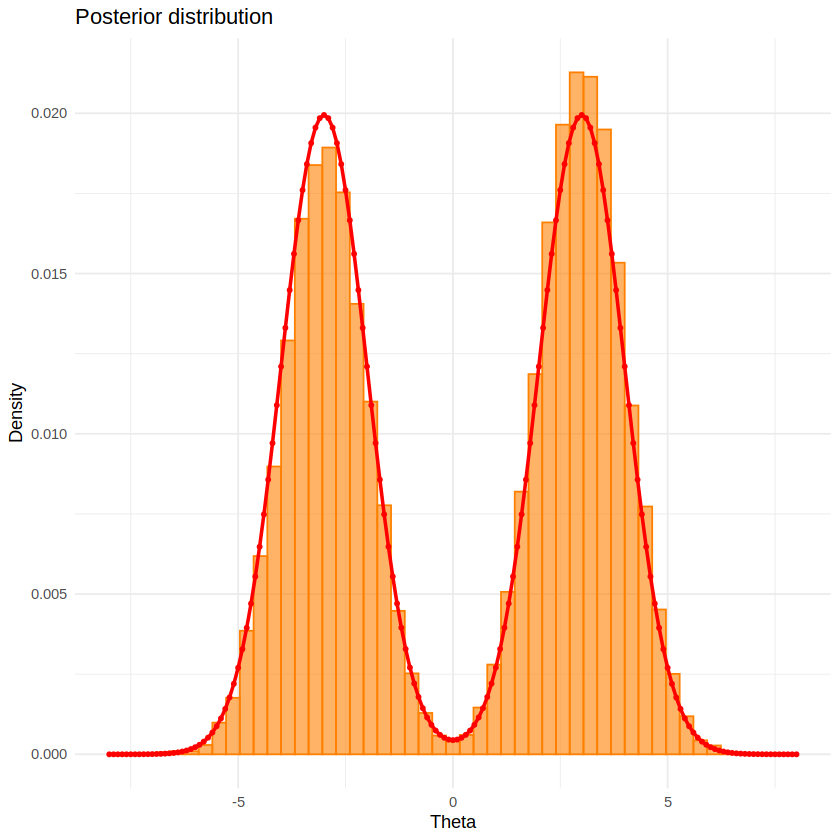

In [4]:
random_theta <- rnorm(1, 0, 1)
n_sample <- 100000
out <- metropolis_sampler(random_theta, n_sample)

n_bins <- 50
bin_w <- (max(theta_values) - min(theta_values)) / n_bins

ggplot(data = data.frame(out$value), aes(x = out$value)) +
  geom_histogram(aes(y = after_stat(count / sum(count)) * bin_w),
                 color = "#ff8000", fill = "#ff8000", binwidth = bin_w,
                 bins = n_bins, alpha = 0.6) +
  geom_point(data = data.frame(theta_values, post_values),
             aes(x = theta_values, y = post_values), color = "red", size = 1) +
  geom_line(data = data.frame(theta_values, post_values),
            aes(x = theta_values, y = post_values), color = "red",
            linewidth = 1) +
  labs(title = "Posterior distribution",
       x = "Theta",
       y = "Density") +
  xlim(min(theta_values), max(theta_values)) +
  theme_minimal()

Normalized effective size: 310.8521

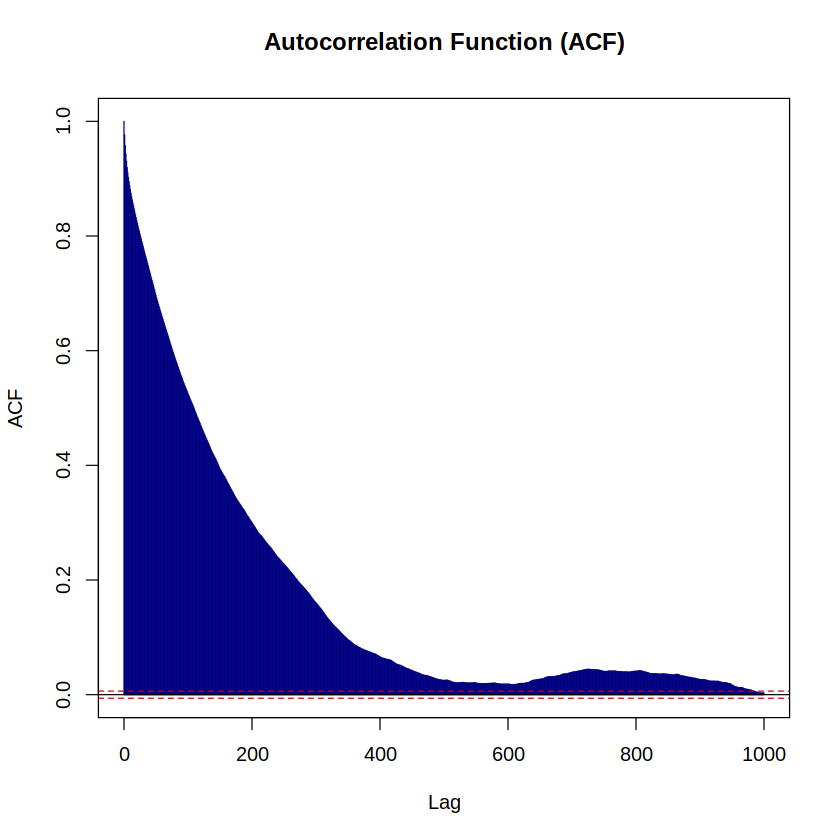

In [5]:
chain <- as.mcmc(out$value)
acf(chain, lag.max = 1000, main = "Autocorrelation Function (ACF)",
    ylim = c(0, 1), col = "navy", ci.col = "#b71111")

cat("Normalized effective size:", effectiveSize(chain))

In [6]:
plot_posterior <- function(values, theta_values, post_values, n_bins) {
  bin_w <- (max(theta_values) - min(theta_values)) / n_bins

  p <- ggplot(data = data.frame(values), aes(x = values)) +
    geom_histogram(aes(y = after_stat(count / sum(count)) * bin_w),
                   color = "#ffc800", fill = "#ffc800", binwidth = bin_w,
                   bins = n_bins, alpha = 0.6) +
    labs(title = "Posterior distribution",
         x = "Theta",
         y = "Density") +
    xlim(min(theta_values), max(theta_values)) +
    theme_minimal()

  print(p)
}

plot_acf <- function(out, thinning, lag_max) {
  thinned_out <- out[seq(1, to = nrow(out), by = thinning), ]
  chain <- as.mcmc(thinned_out$value)
  norm <- nrow(out) / thinning

  acf(chain, lag.max = lag_max, main = "Autocorrelation Function (ACF)",
      ylim = c(-0.1, 1), col = "navy", ci.col = "#b71111")

  return(effectiveSize(chain) / norm)
}

Running with burn_in = 100 and thinning = 1 


Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_bar()`).”


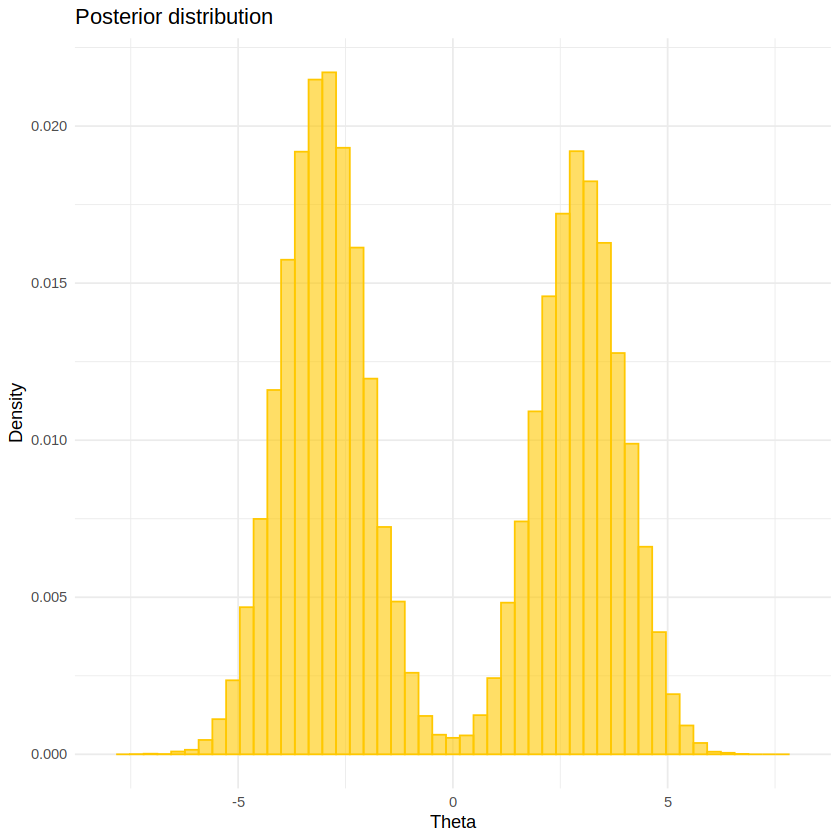

Normalized effective size = 0.003476982 
#################################

Running with burn_in = 100 and thinning = 5 


Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_bar()`).”


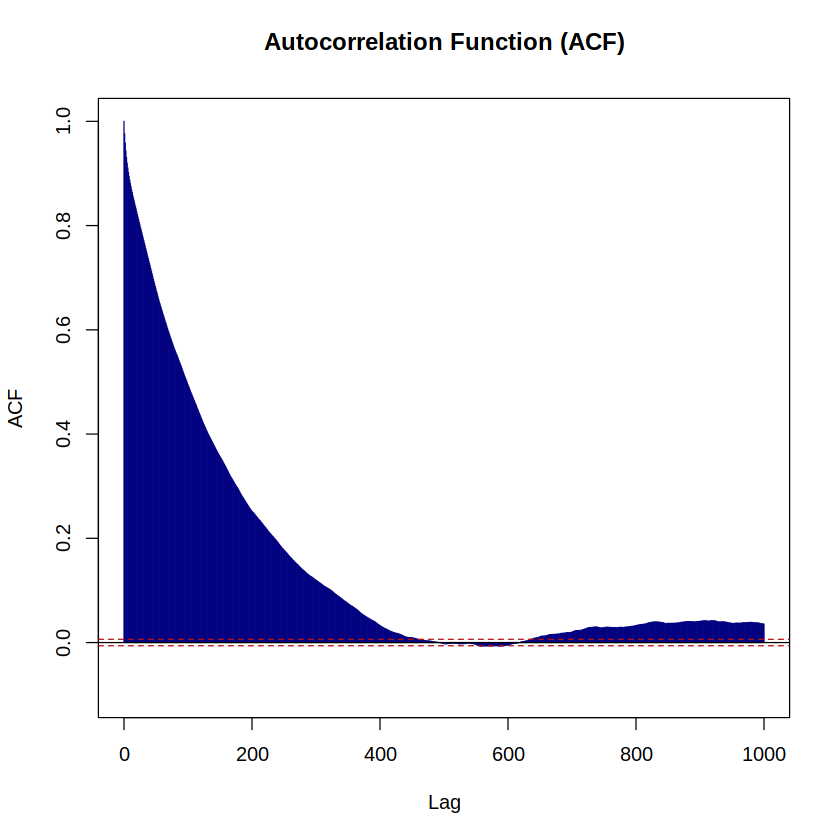

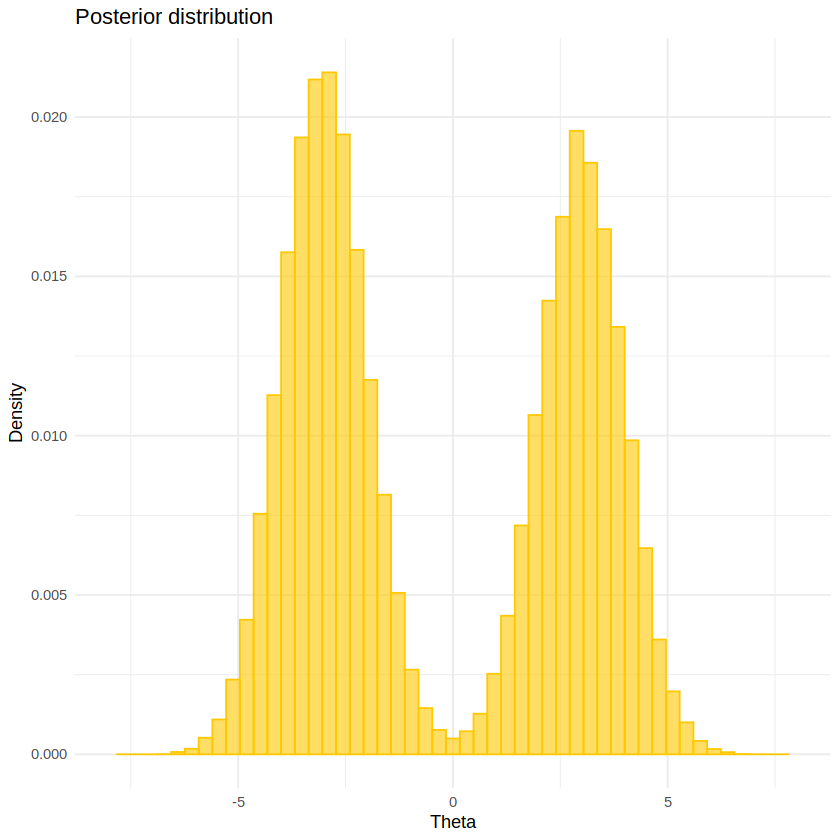

Normalized effective size = 0.01577302 
#################################

Running with burn_in = 100 and thinning = 10 


Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_bar()`).”


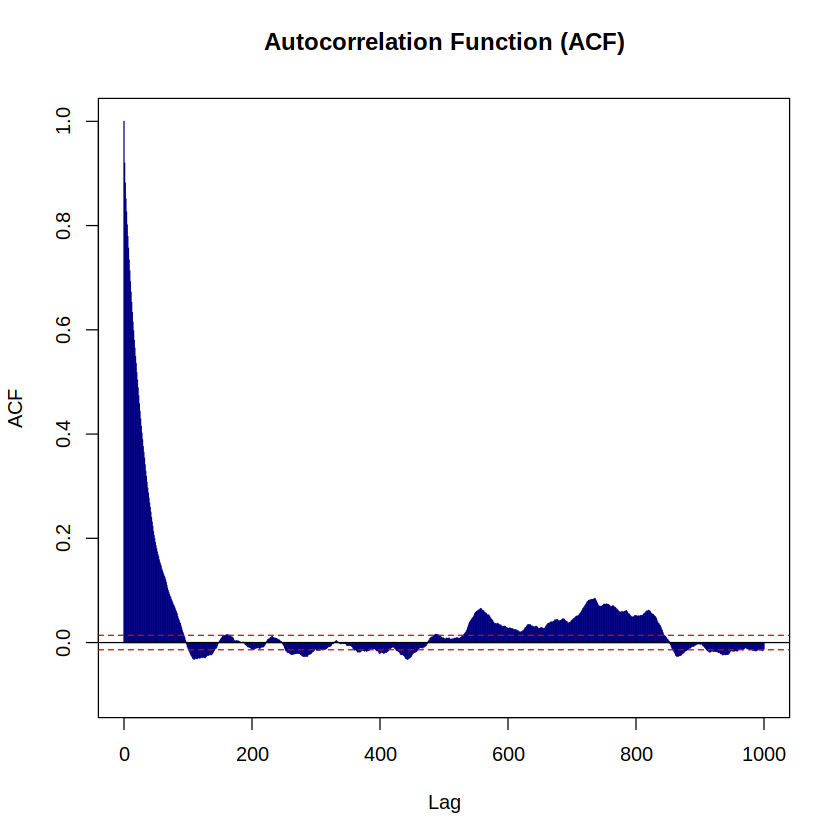

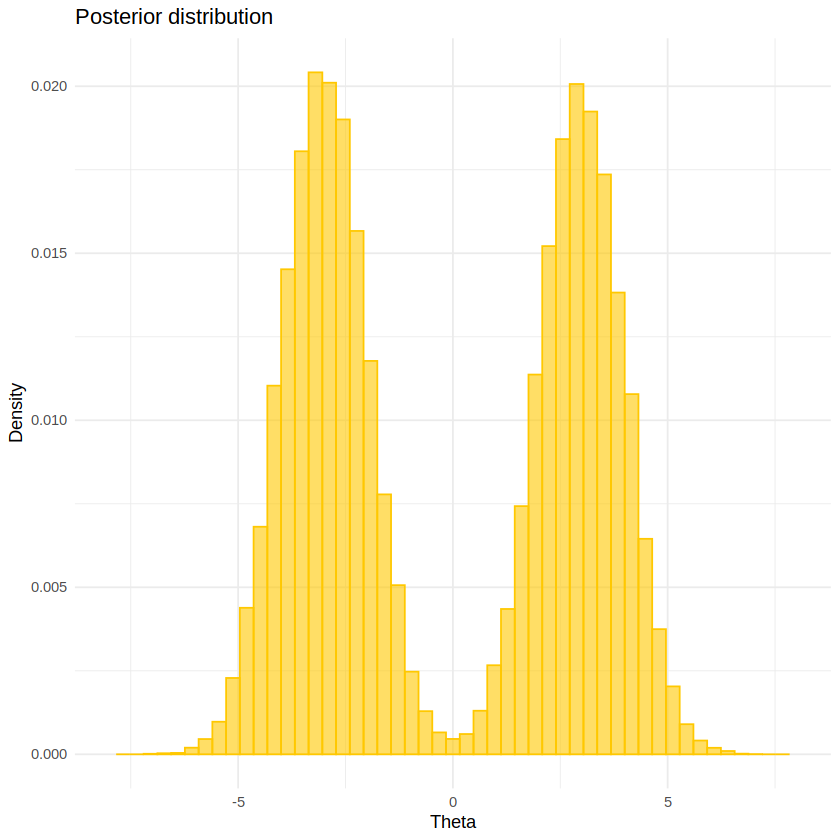

Normalized effective size = 0.03795068 
#################################

Running with burn_in = 100 and thinning = 15 


Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_bar()`).”


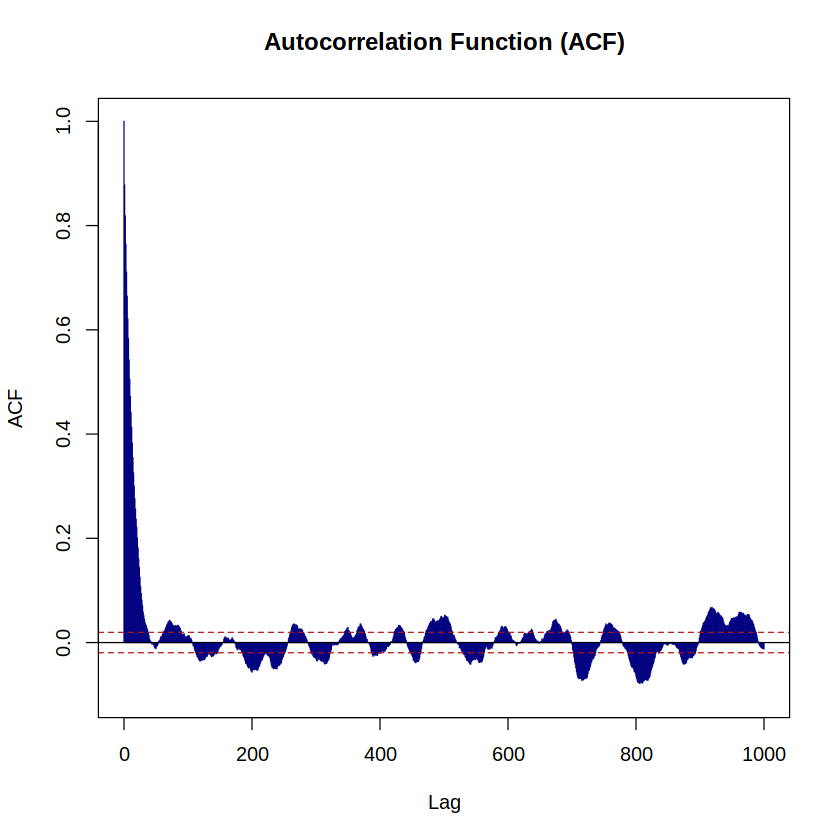

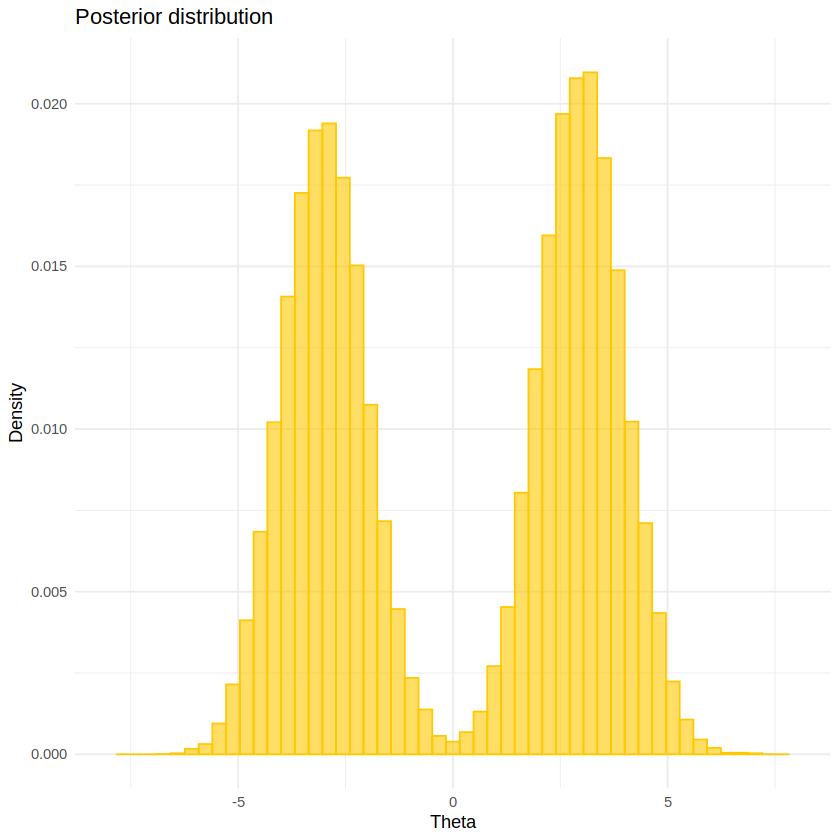

Normalized effective size = 0.04351737 
#################################

Running with burn_in = 100 and thinning = 20 


Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_bar()`).”


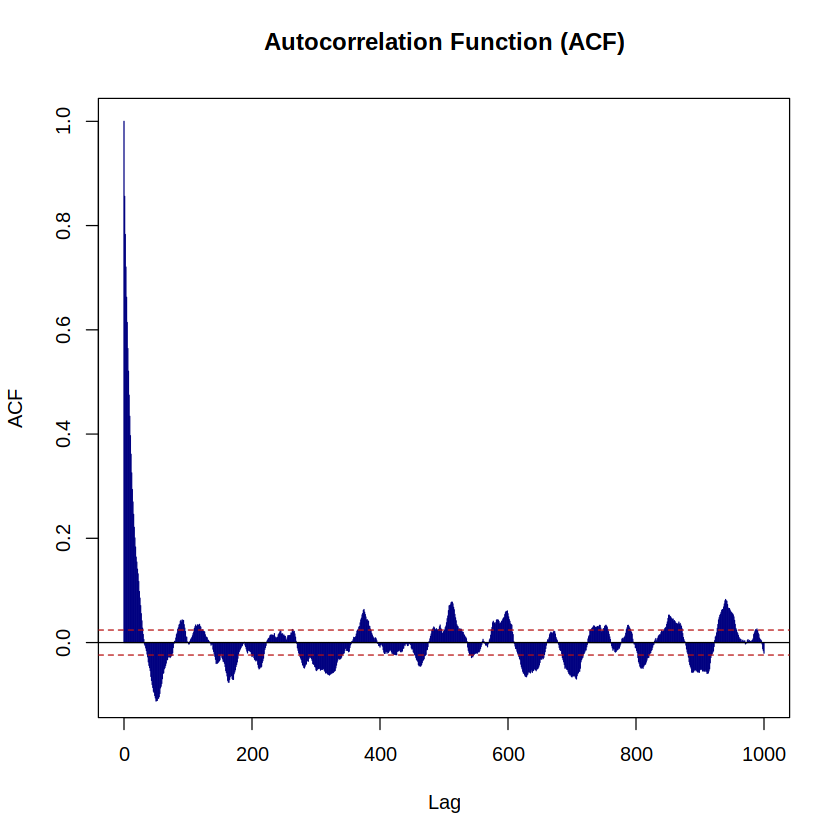

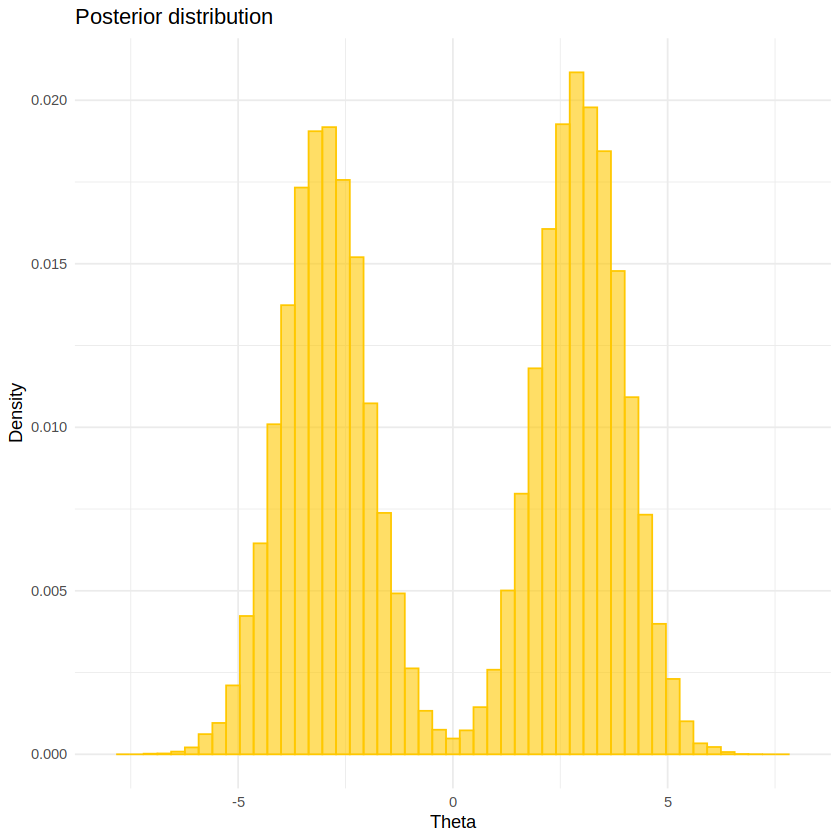

Normalized effective size = 0.07485143 
#################################

Running with burn_in = 1000 and thinning = 1 


Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_bar()`).”


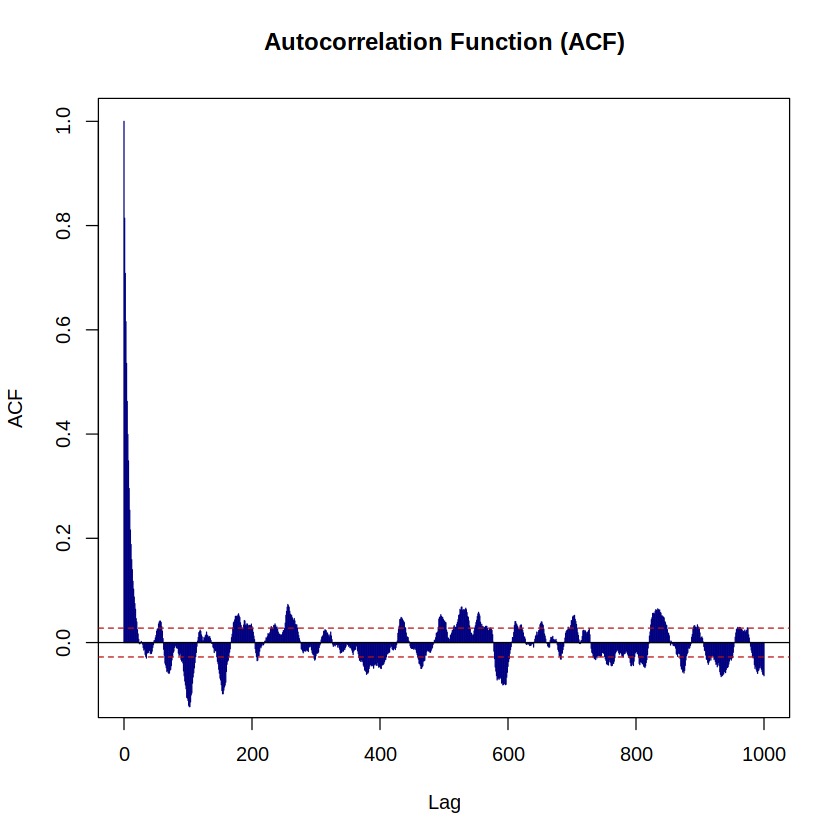

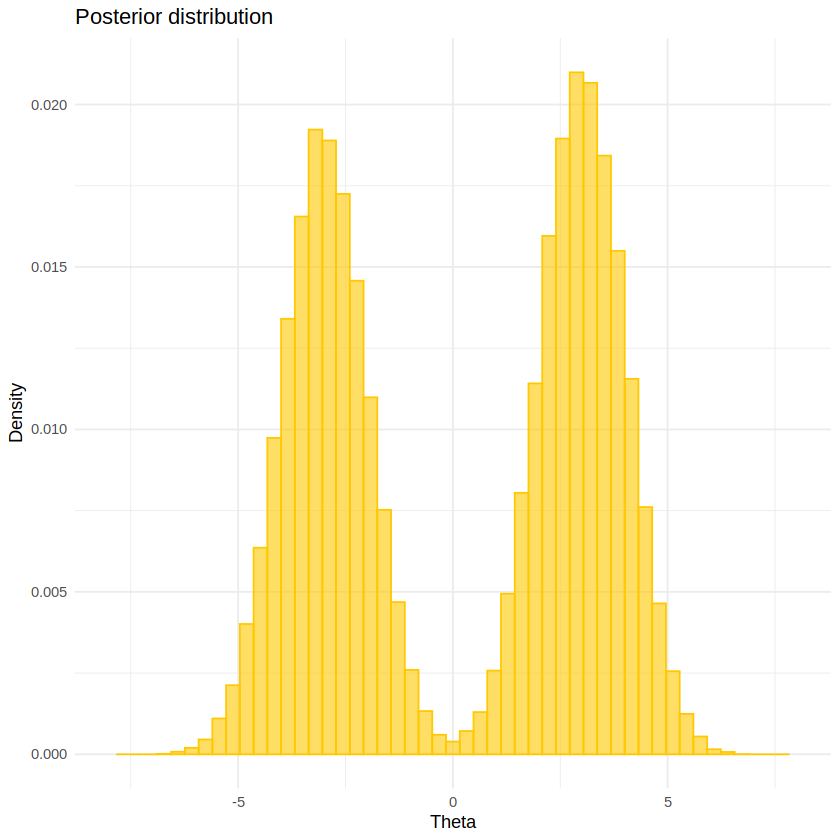

Normalized effective size = 0.003176671 
#################################

Running with burn_in = 1000 and thinning = 5 


Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_bar()`).”


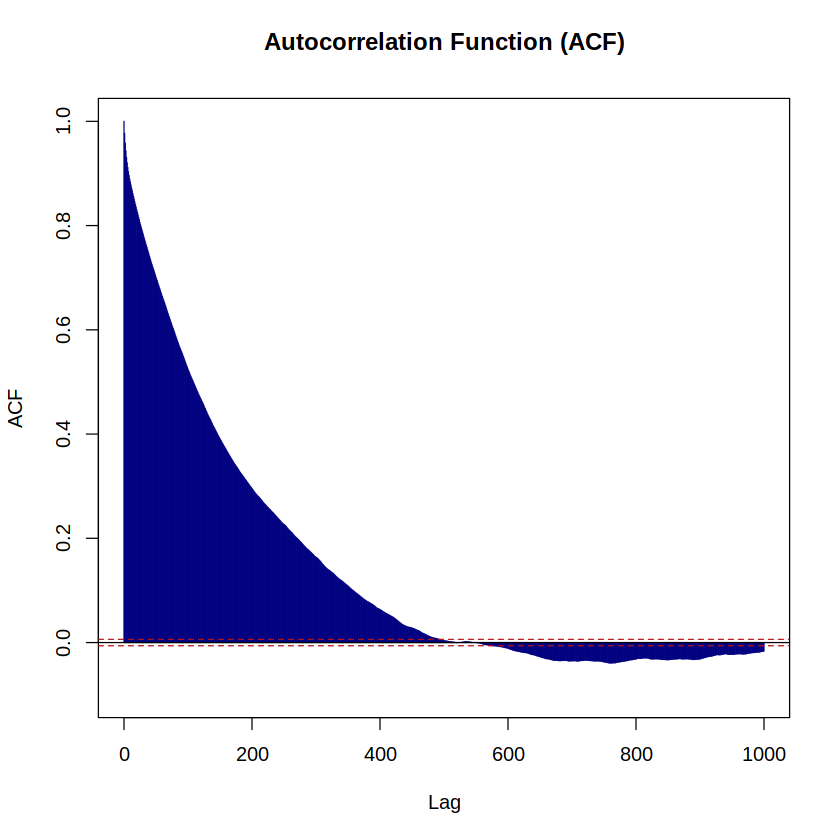

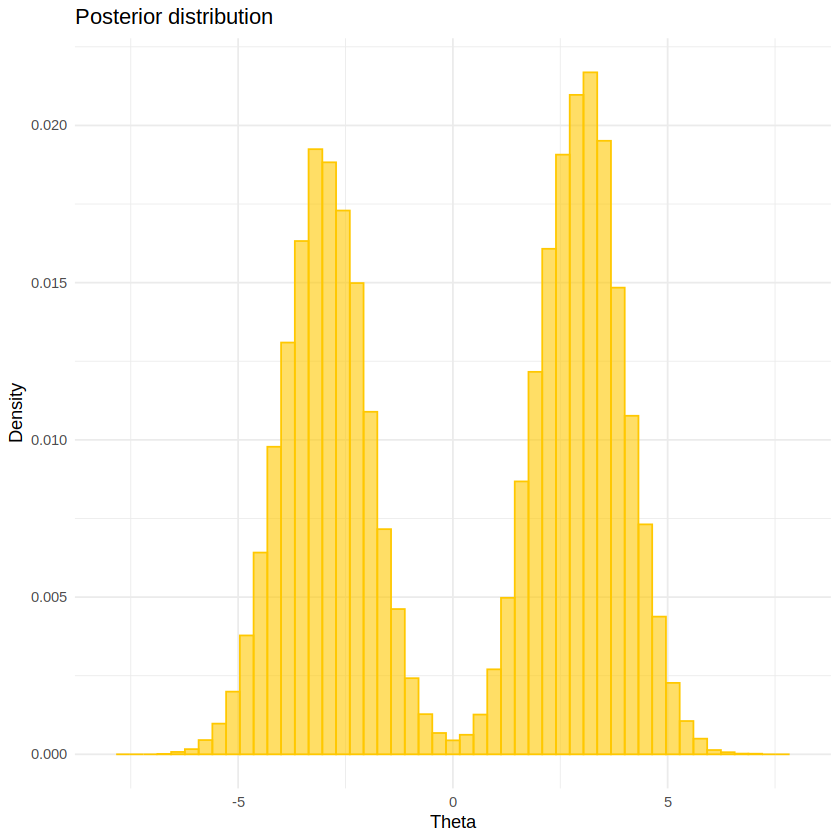

Normalized effective size = 0.01602636 
#################################

Running with burn_in = 1000 and thinning = 10 


Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_bar()`).”


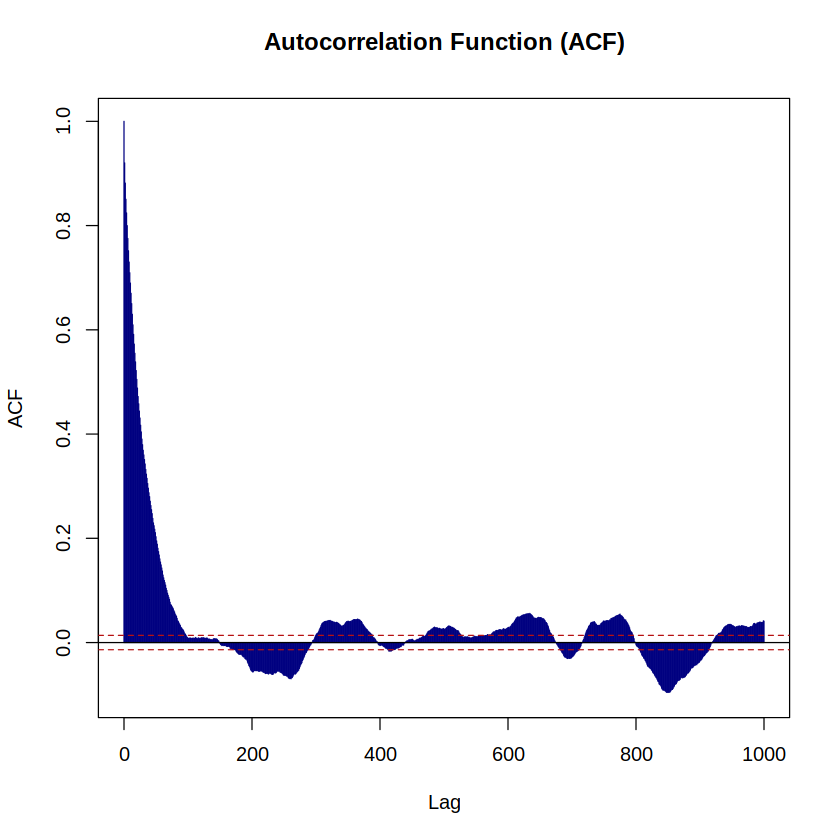

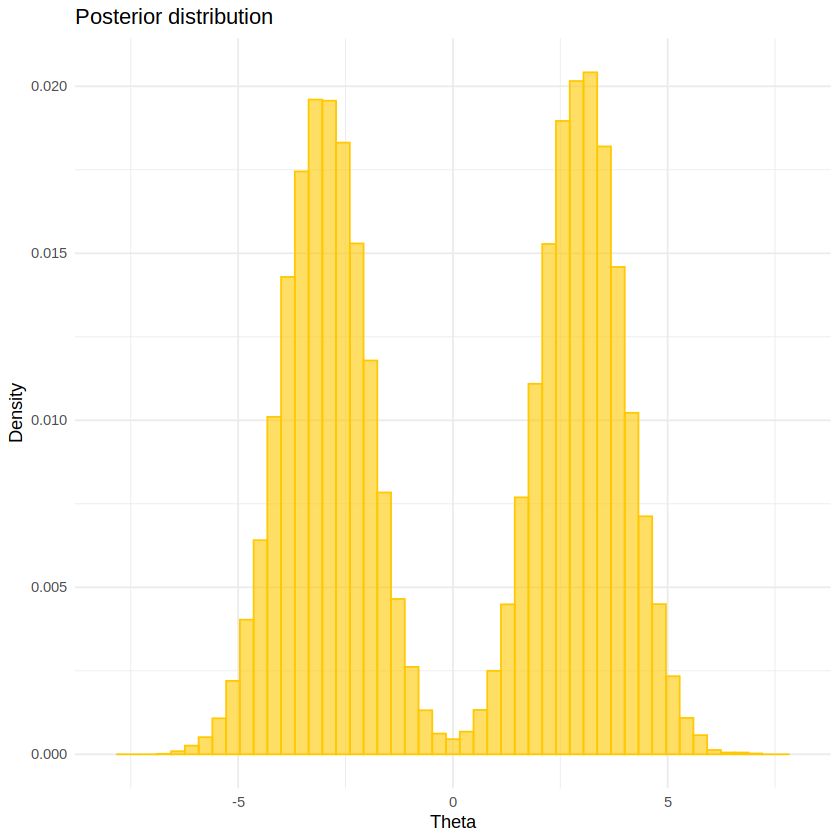

Normalized effective size = 0.03277591 
#################################

Running with burn_in = 1000 and thinning = 15 


Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_bar()`).”


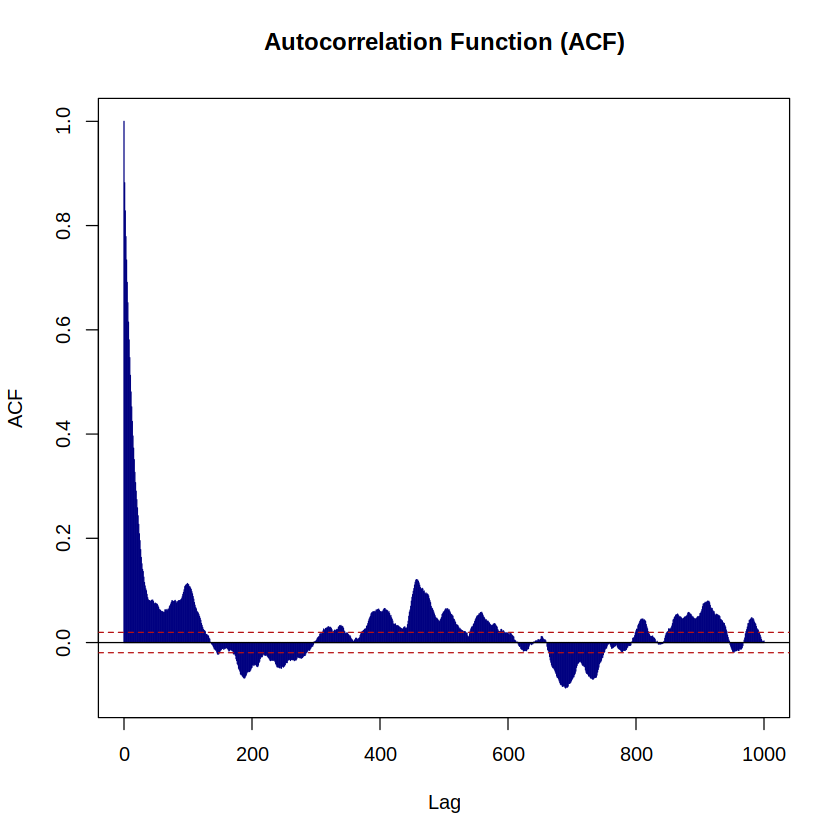

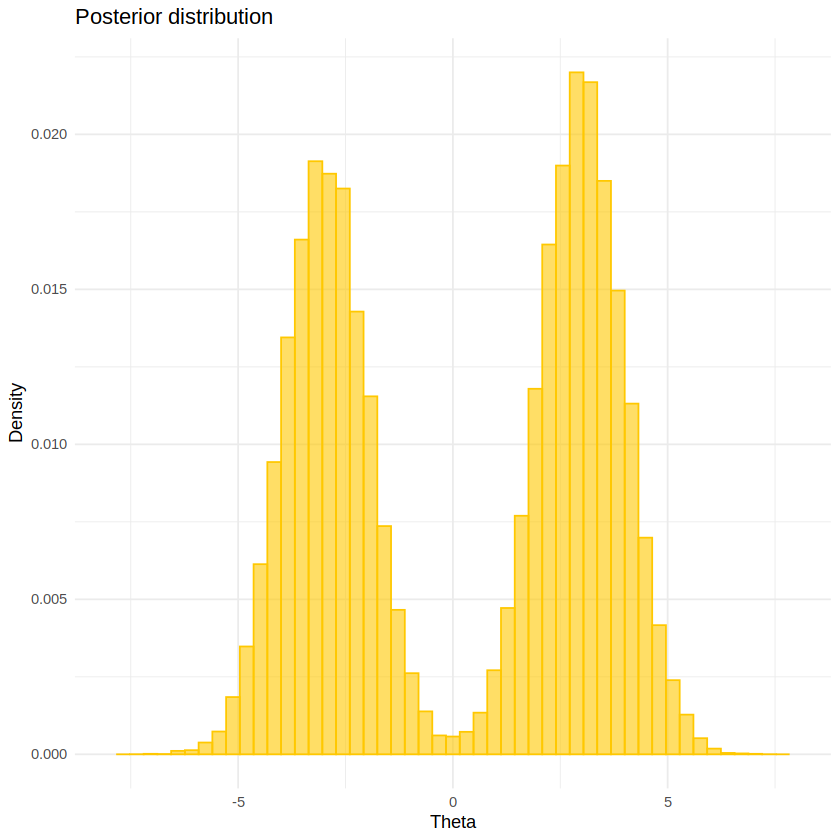

Normalized effective size = 0.0477916 
#################################

Running with burn_in = 1000 and thinning = 20 


Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_bar()`).”


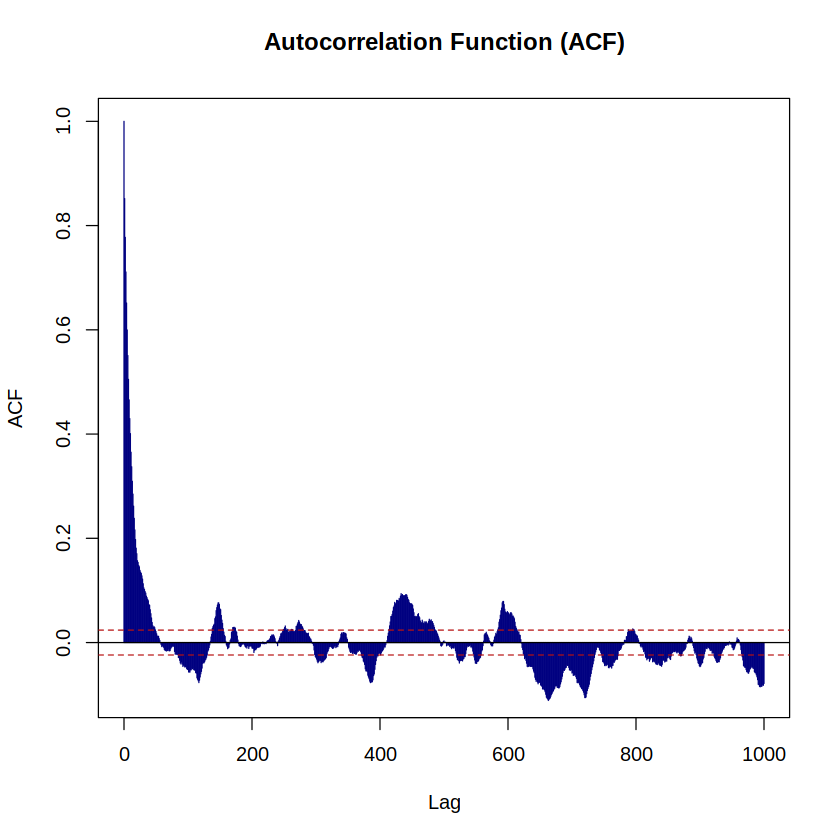

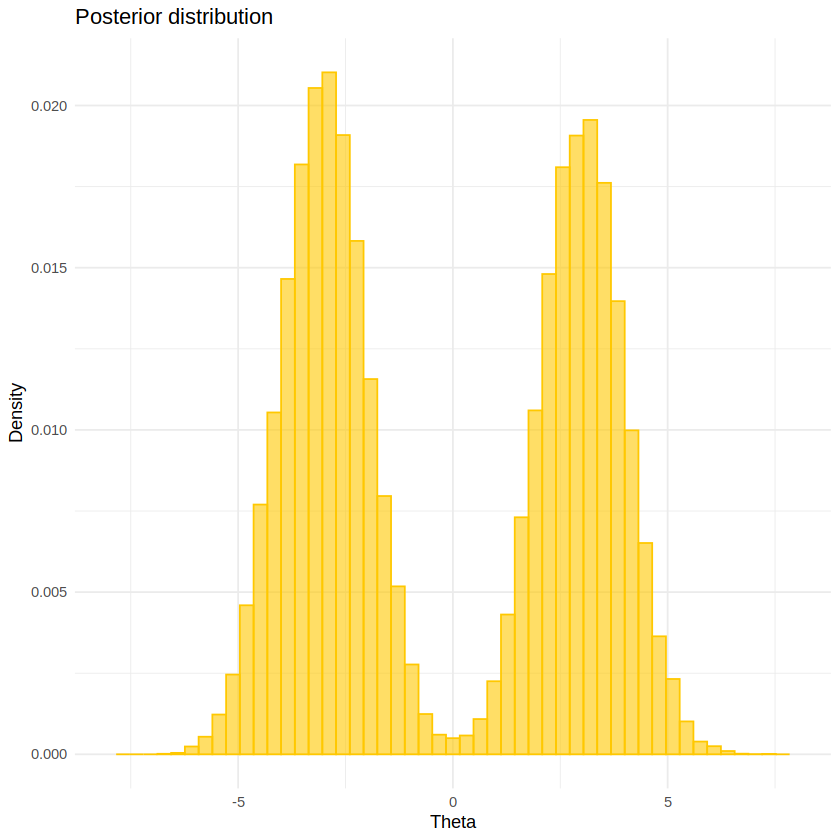

Normalized effective size = 0.05893402 
#################################

Running with burn_in = 5000 and thinning = 1 


Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_bar()`).”


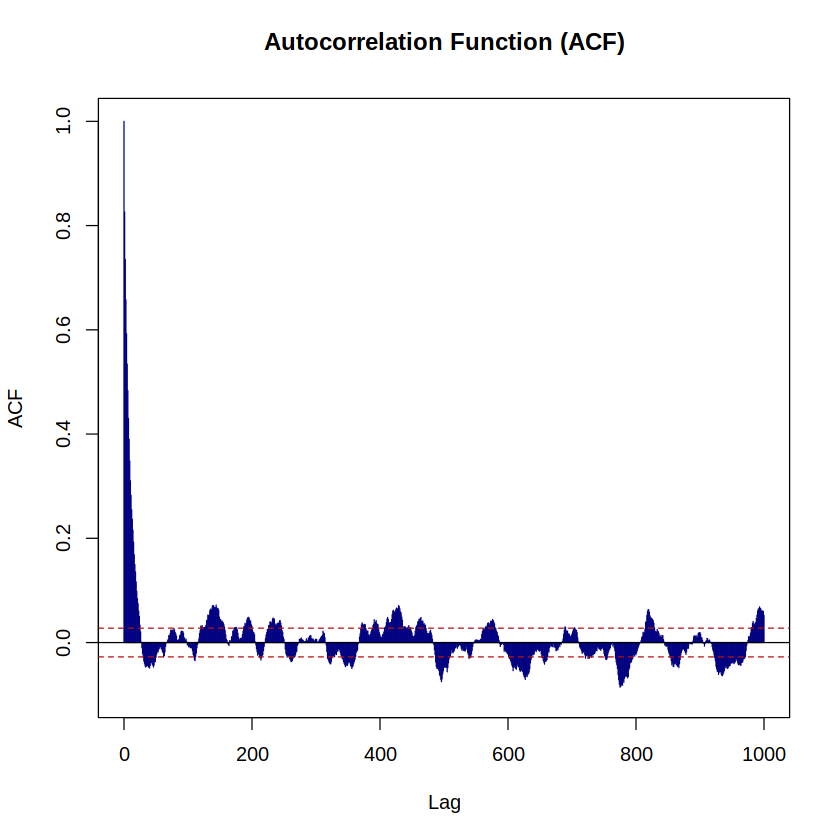

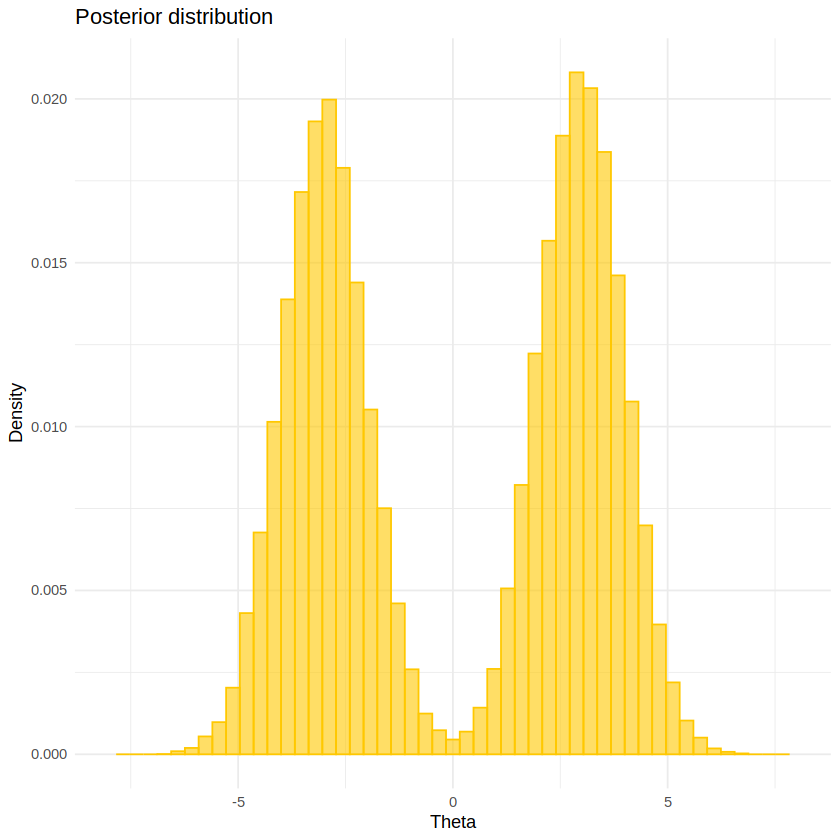

Normalized effective size = 0.003375681 
#################################

Running with burn_in = 5000 and thinning = 5 


Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_bar()`).”


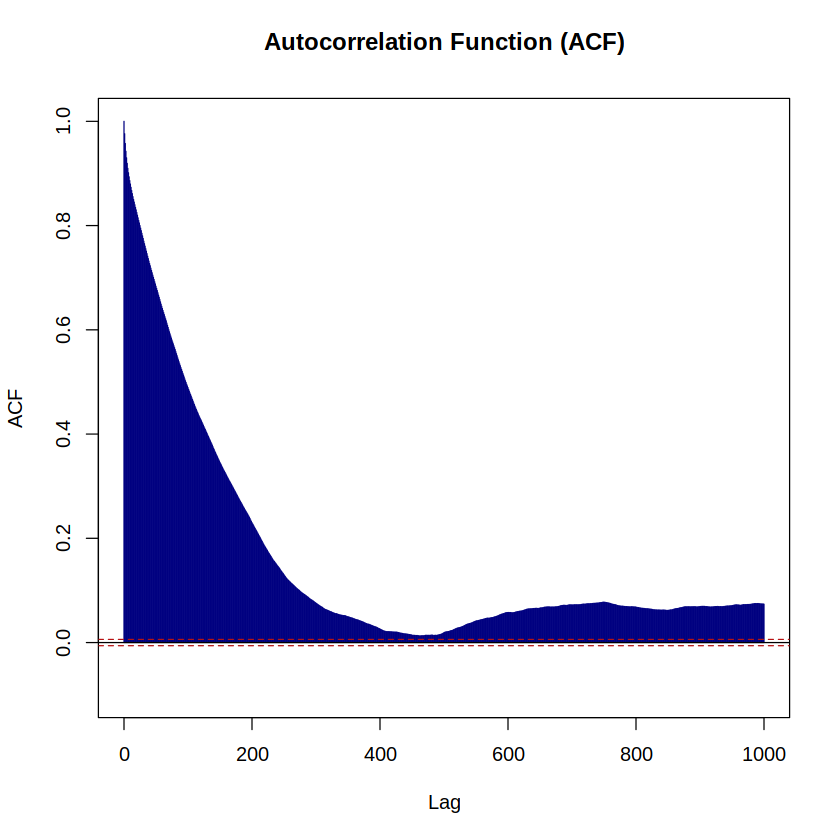

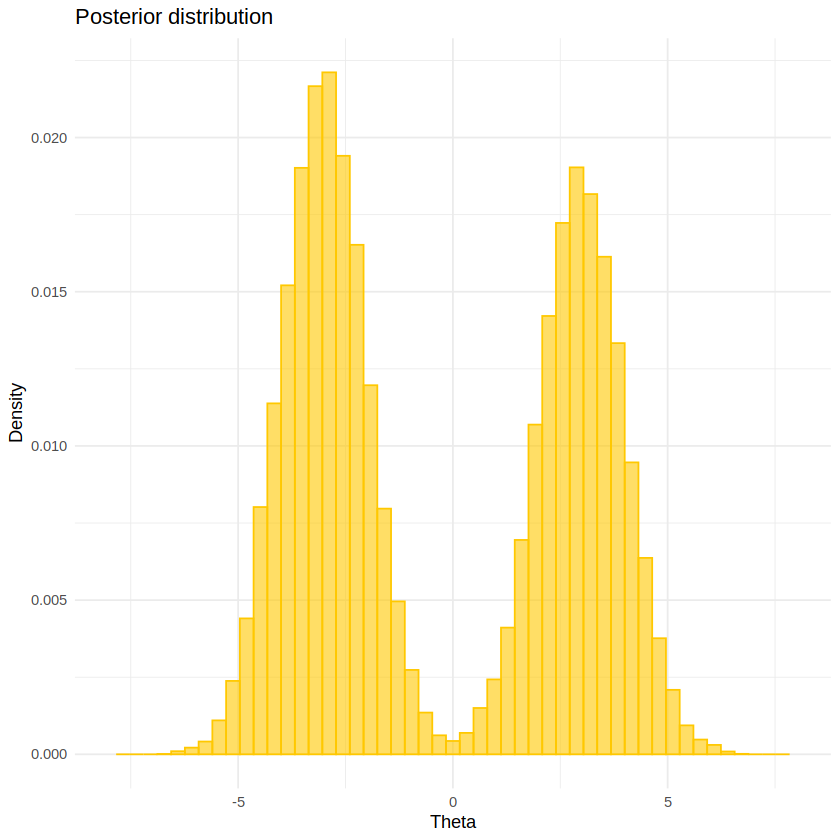

Normalized effective size = 0.01712173 
#################################

Running with burn_in = 5000 and thinning = 10 


Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_bar()`).”


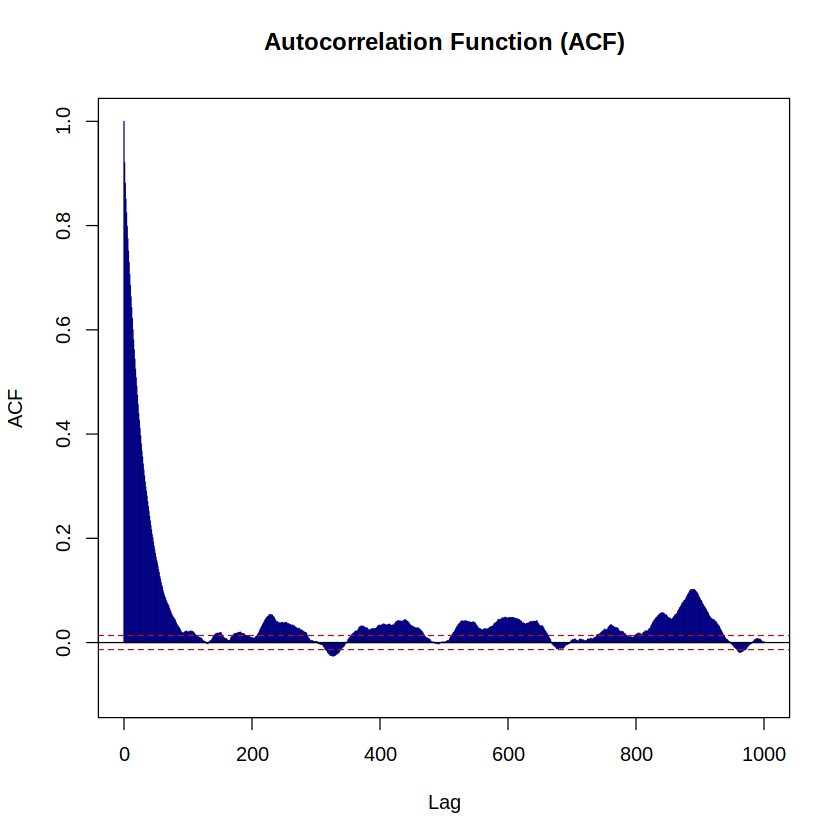

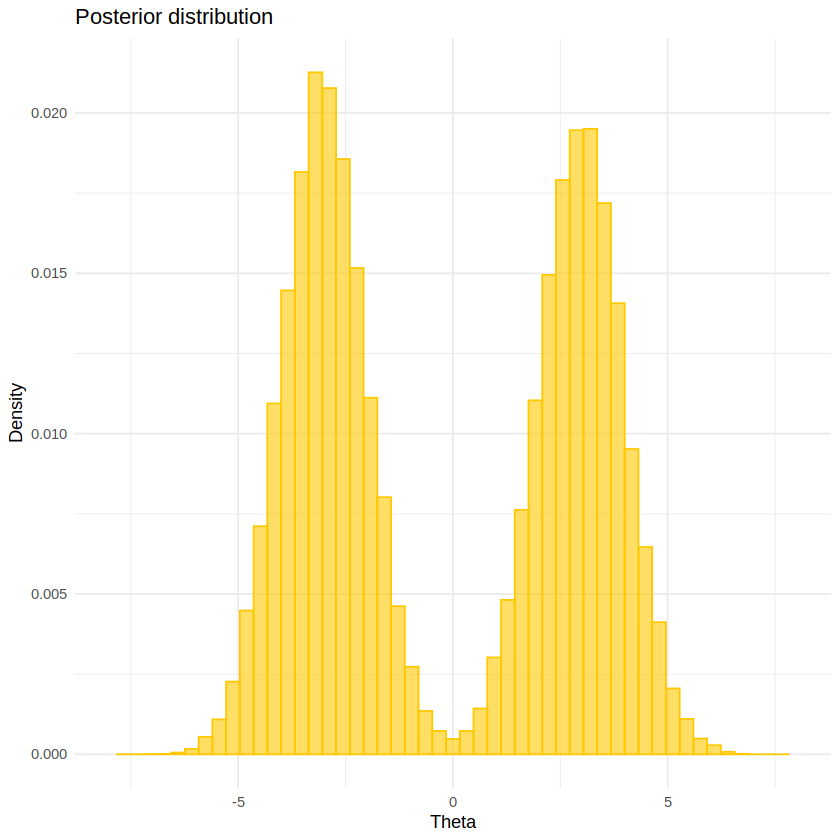

Normalized effective size = 0.03675287 
#################################

Running with burn_in = 5000 and thinning = 15 


Warning message:
“Removed 2 rows containing non-finite outside the scale range (`stat_bin()`).”
Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_bar()`).”


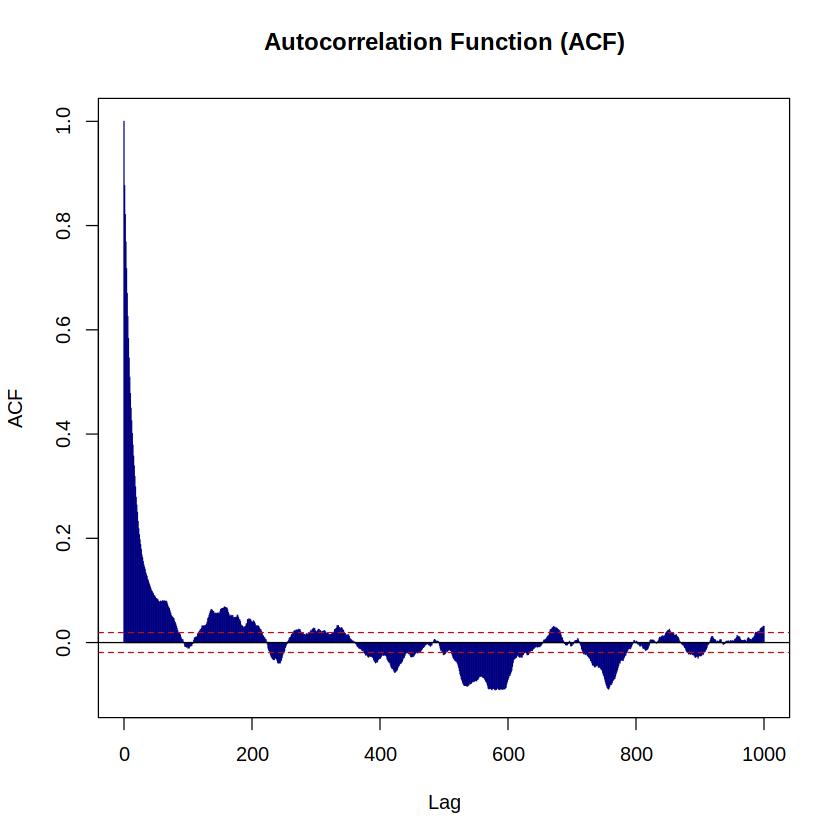

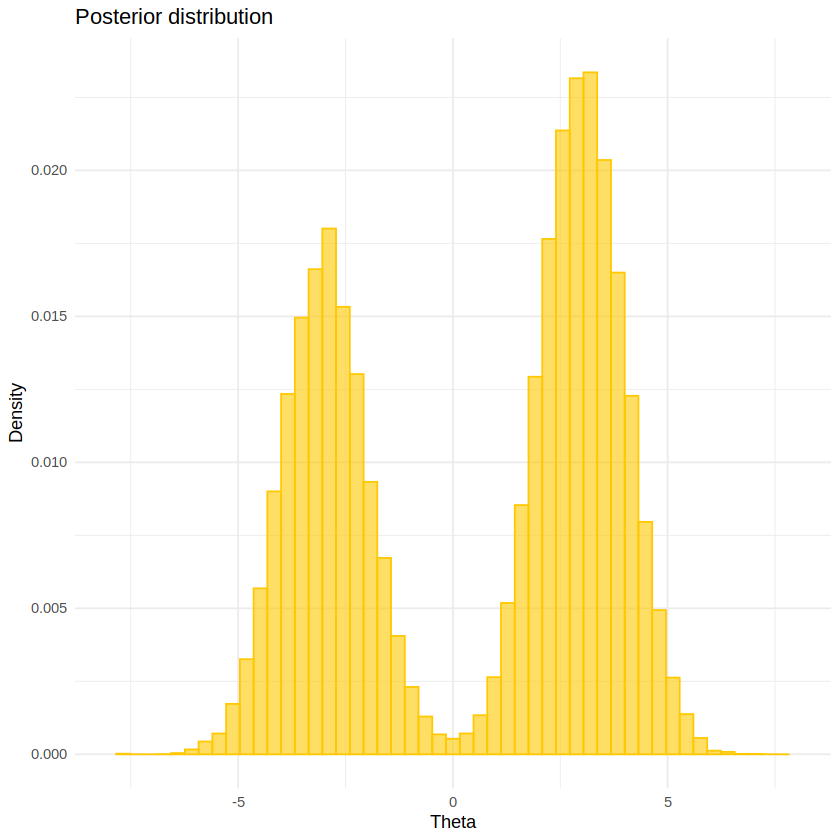

Normalized effective size = 0.05259996 
#################################

Running with burn_in = 5000 and thinning = 20 


Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_bar()`).”


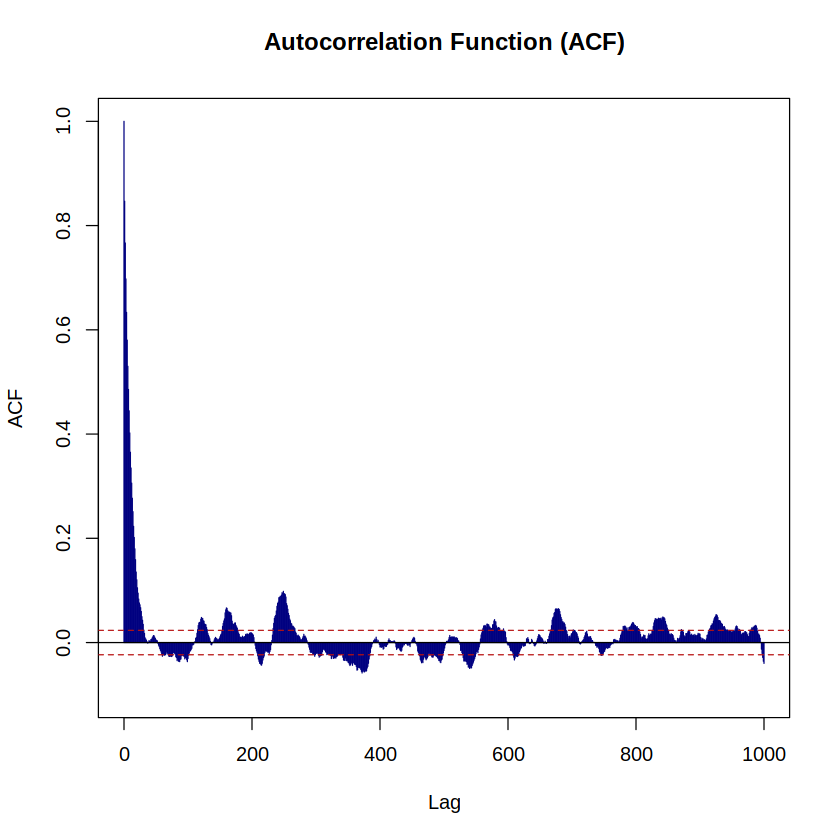

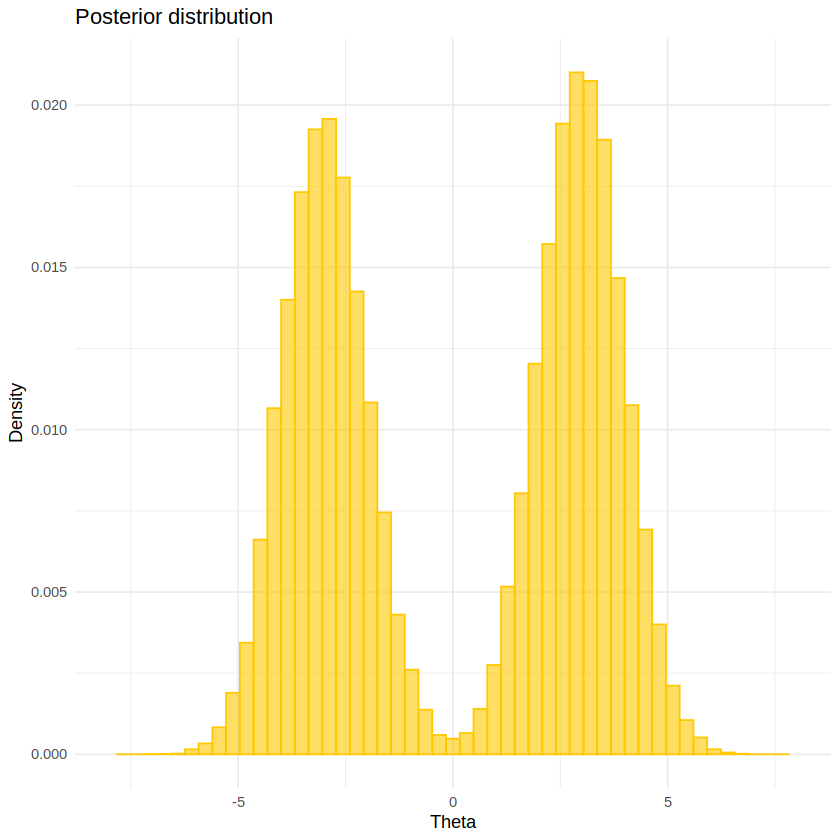

Normalized effective size = 0.05864325 
#################################

Running with burn_in = 10000 and thinning = 1 


Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_bar()`).”


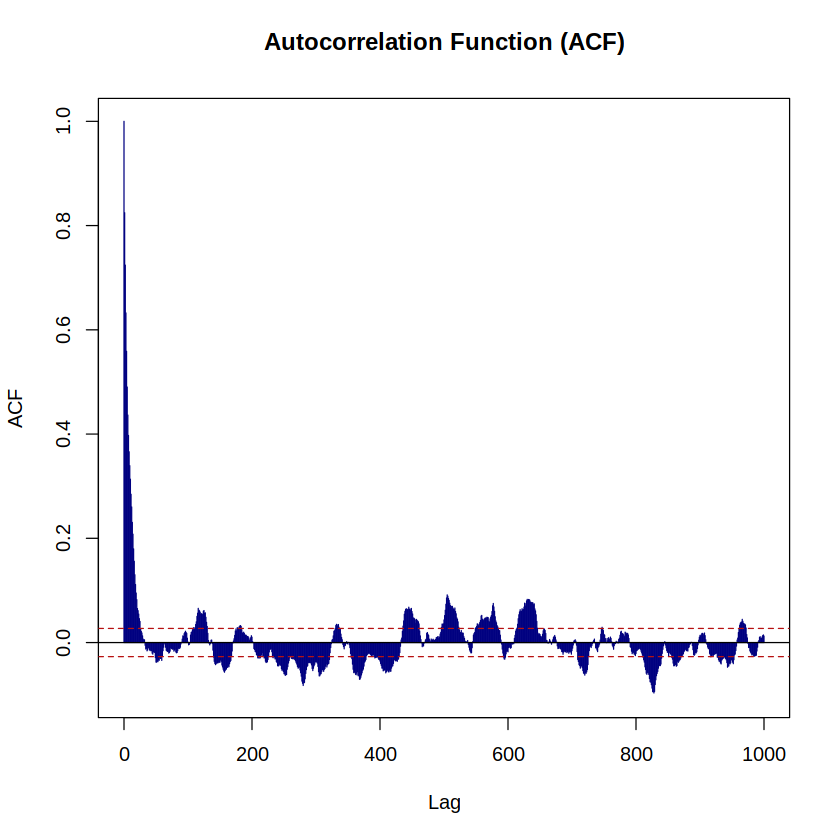

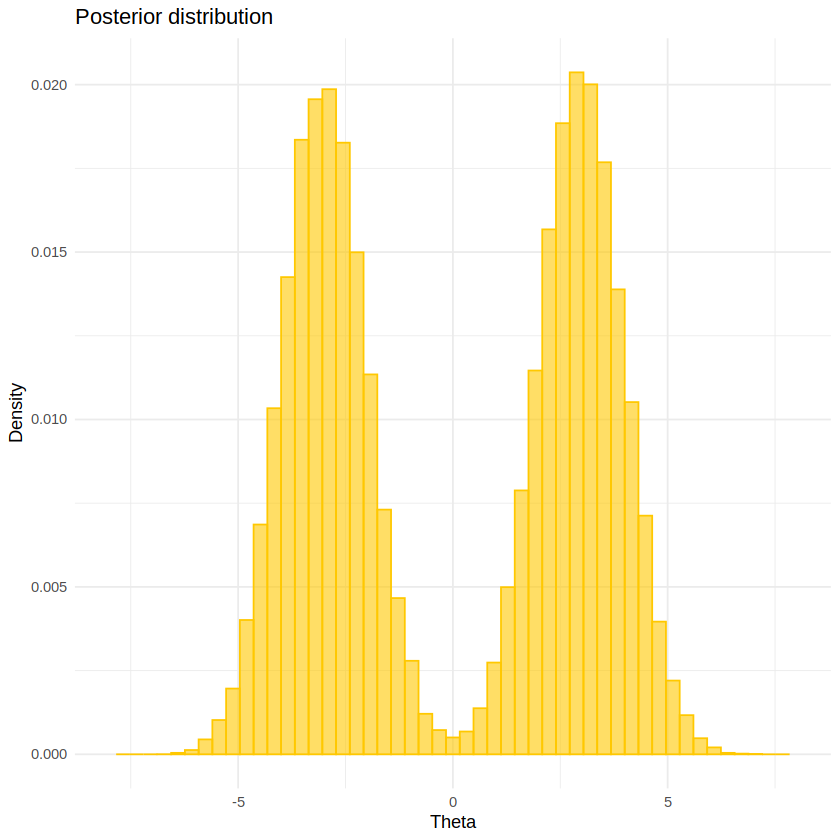

Normalized effective size = 0.00333801 
#################################

Running with burn_in = 10000 and thinning = 5 


Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_bar()`).”


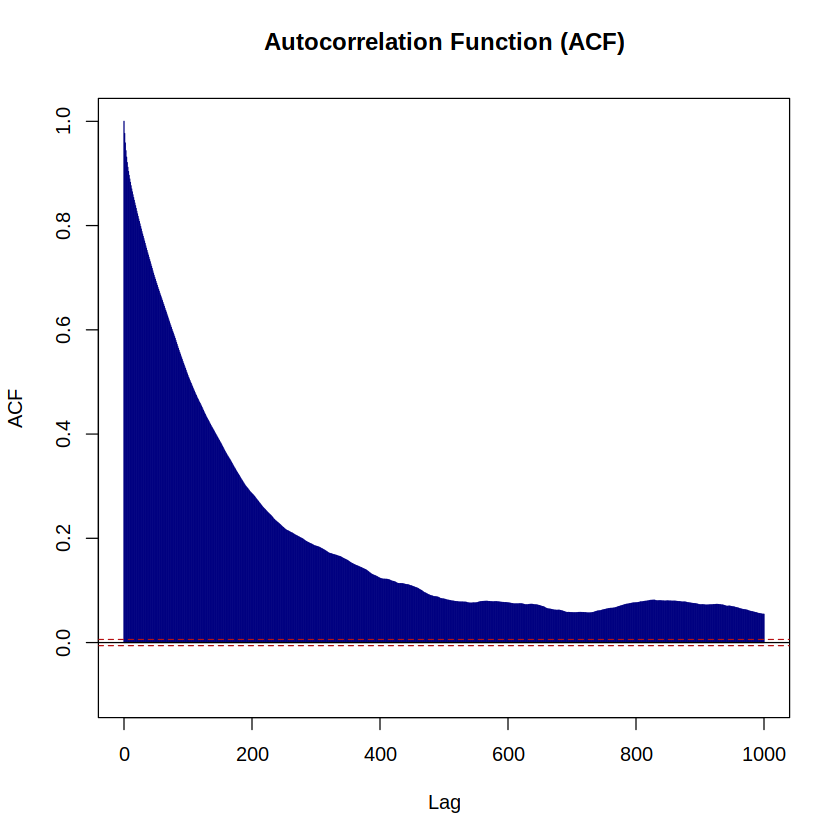

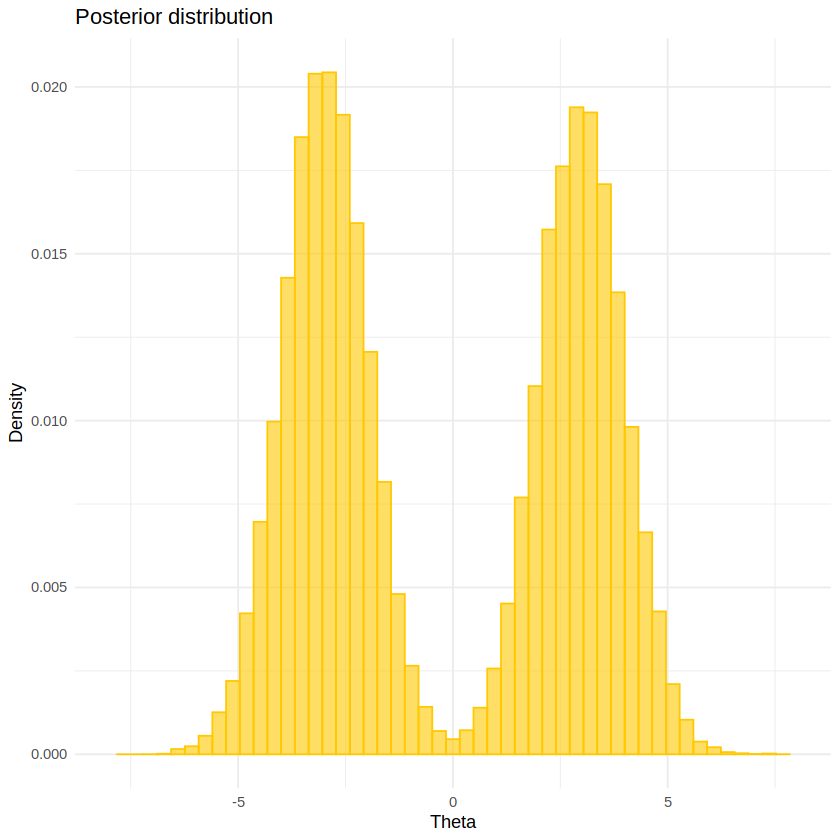

Normalized effective size = 0.0166564 
#################################

Running with burn_in = 10000 and thinning = 10 


Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_bar()`).”


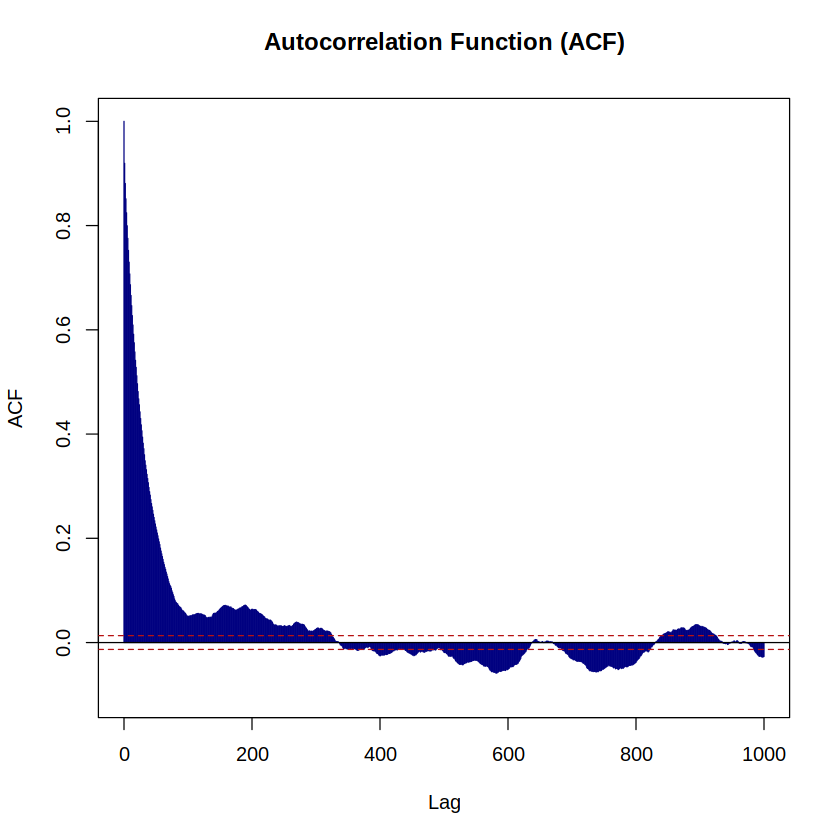

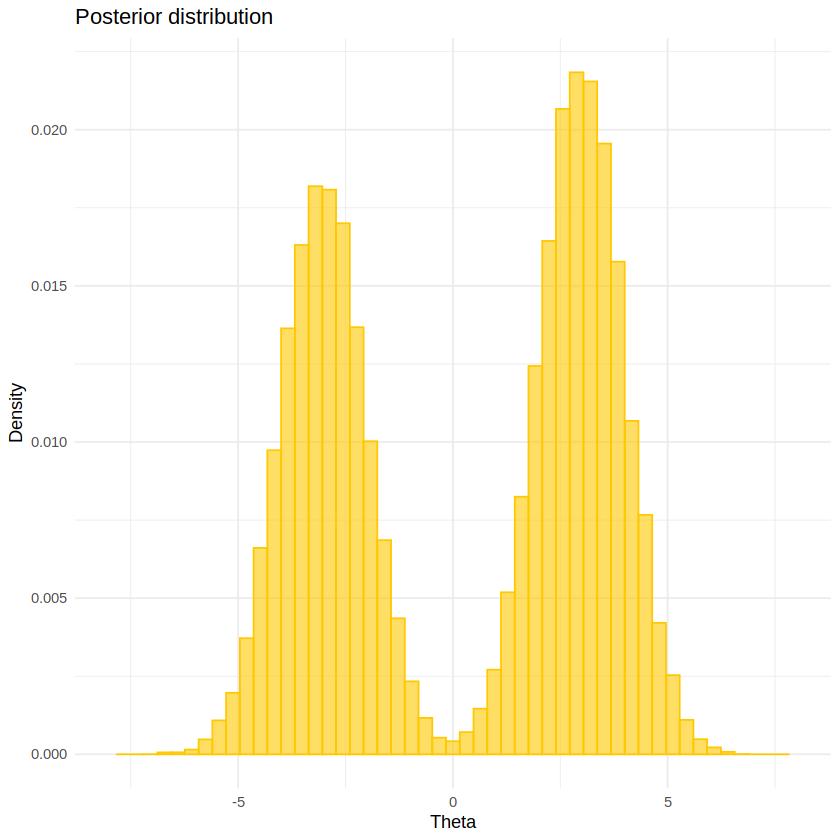

Normalized effective size = 0.03447714 
#################################

Running with burn_in = 10000 and thinning = 15 


Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_bar()`).”


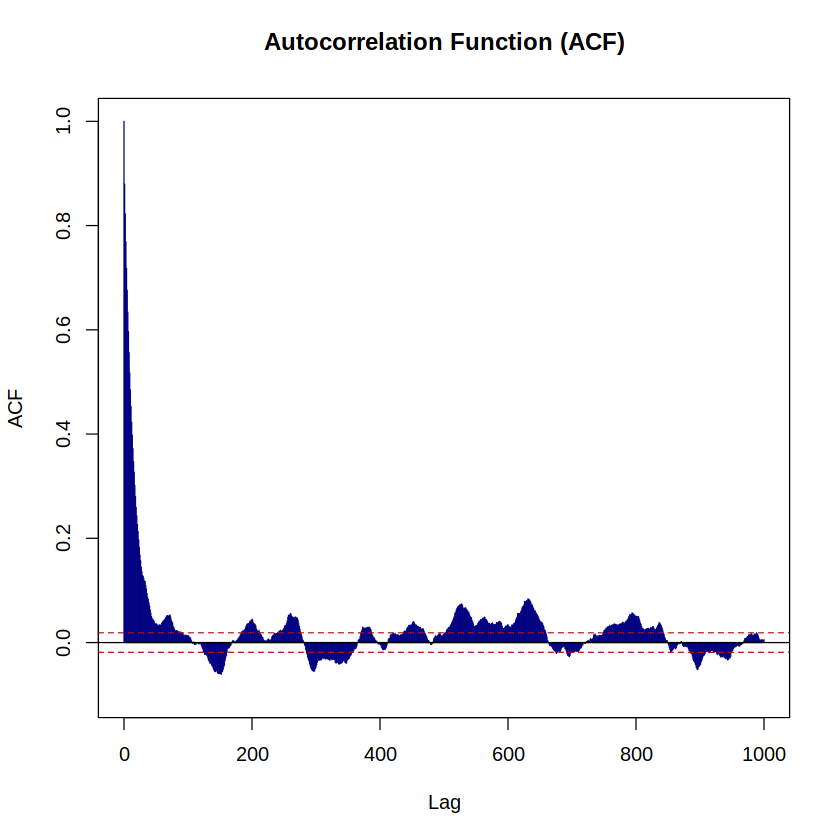

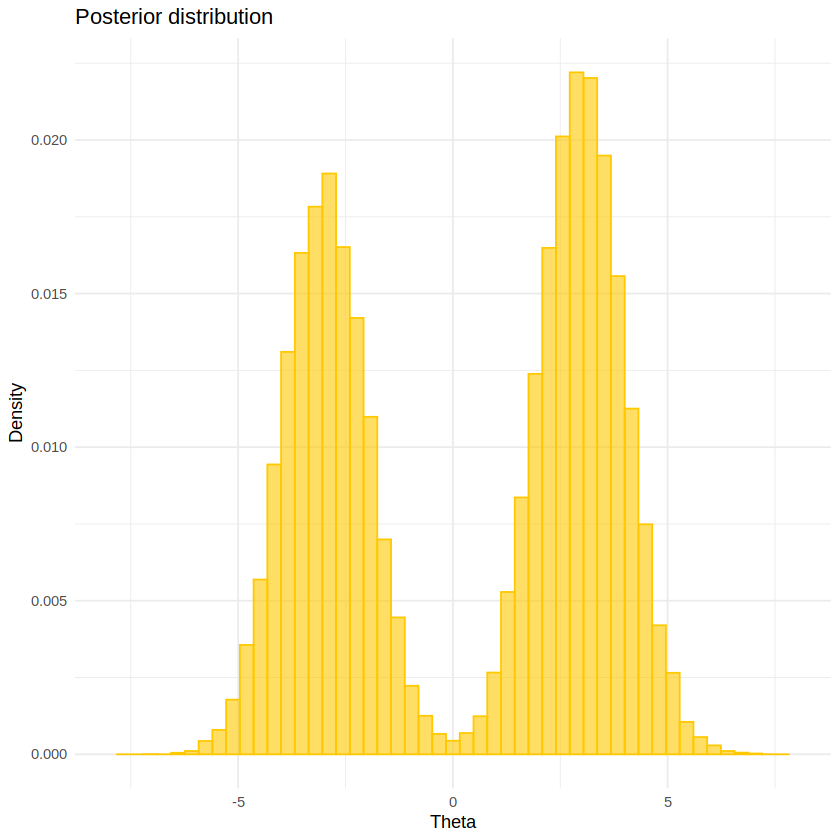

Normalized effective size = 0.04616236 
#################################

Running with burn_in = 10000 and thinning = 20 


Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_bar()`).”


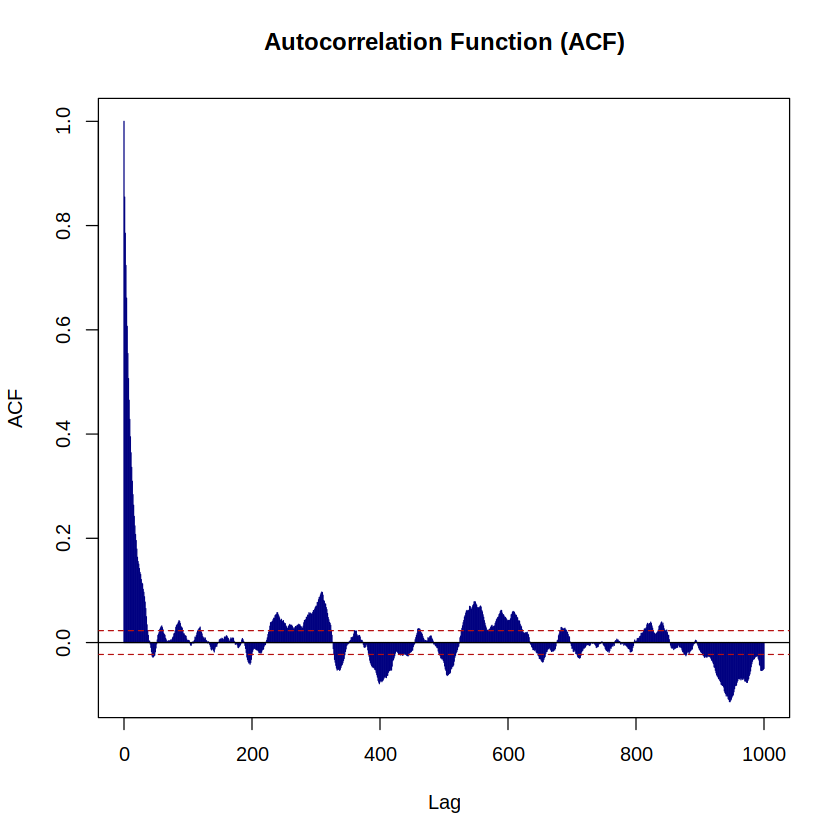

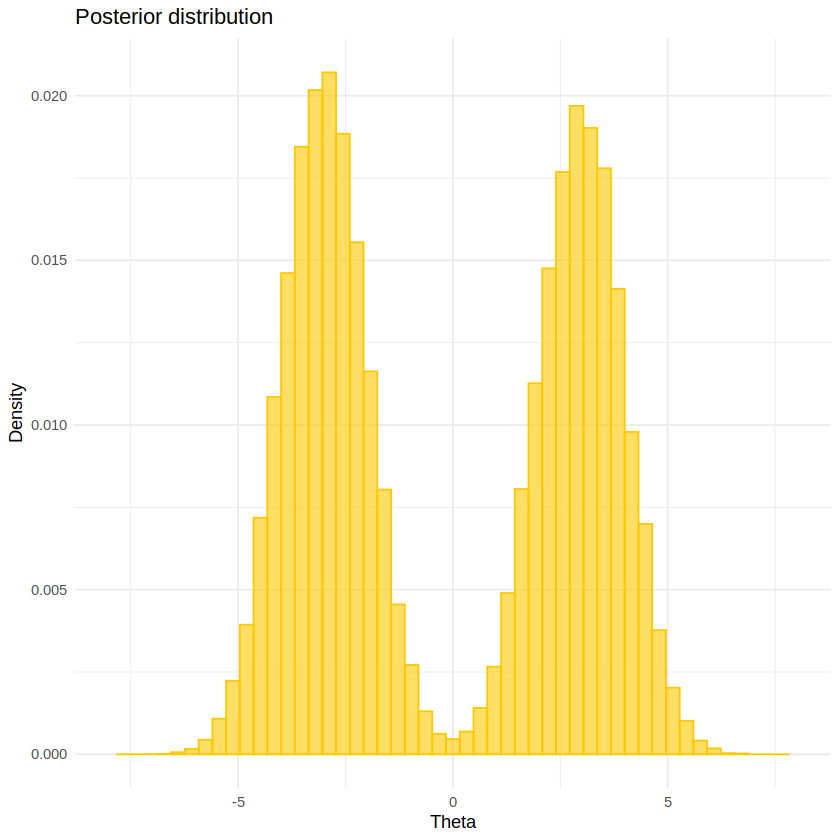

Normalized effective size = 0.0664546 
#################################

Running with burn_in = 20000 and thinning = 1 


Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_bar()`).”


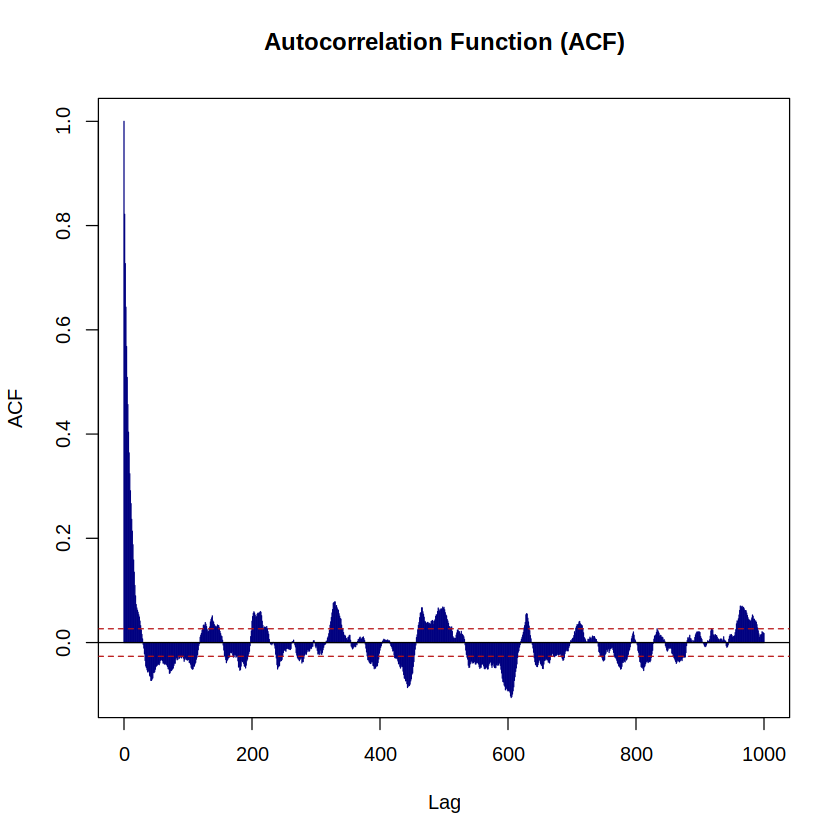

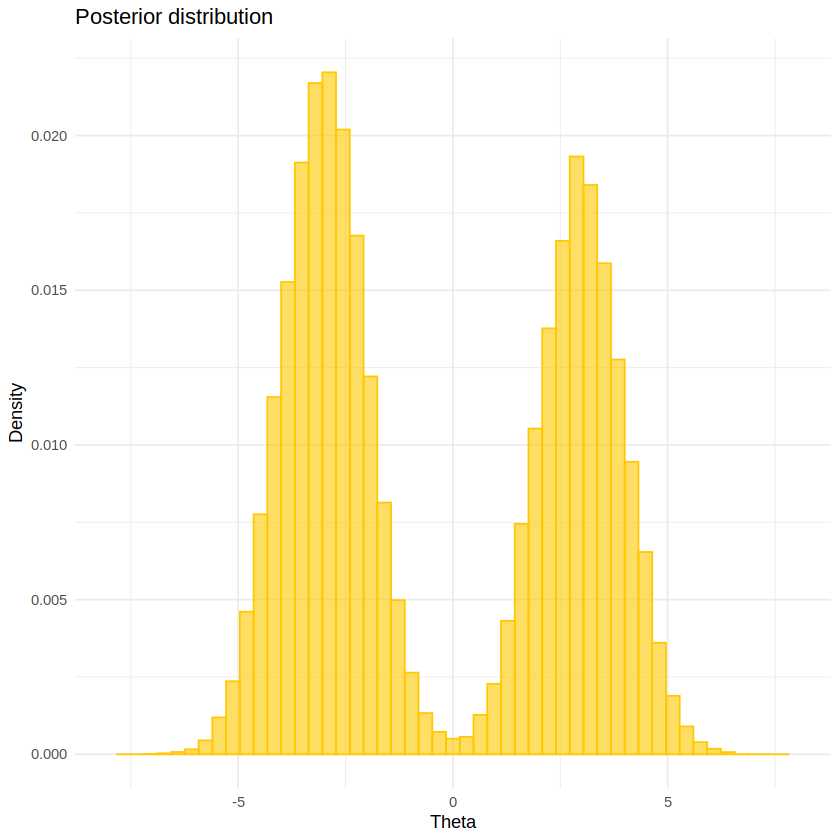

Normalized effective size = 0.003253854 
#################################

Running with burn_in = 20000 and thinning = 5 


Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_bar()`).”


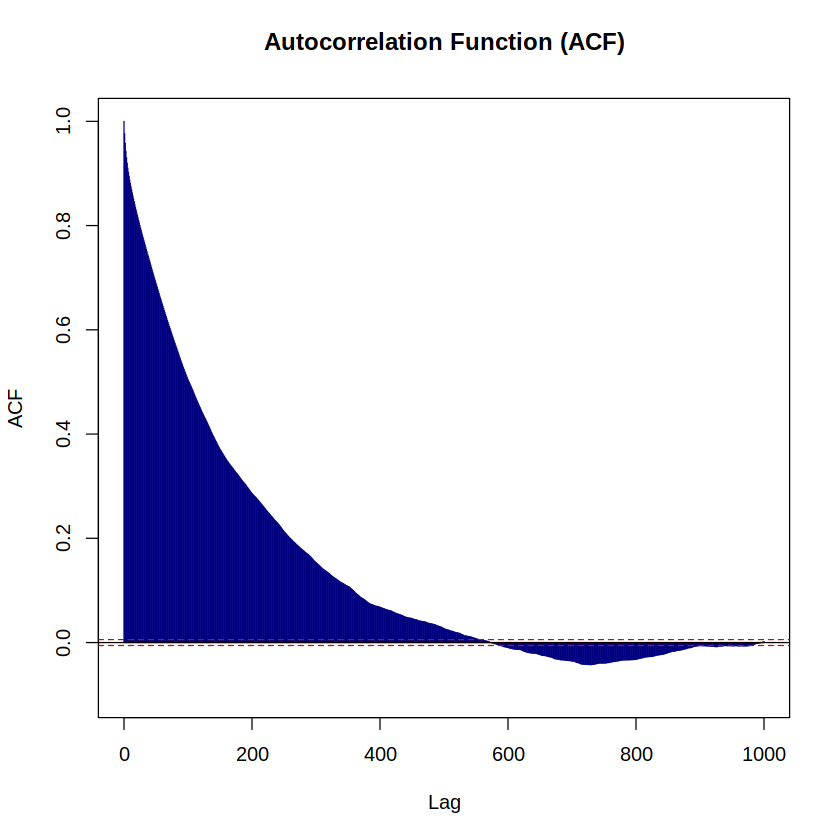

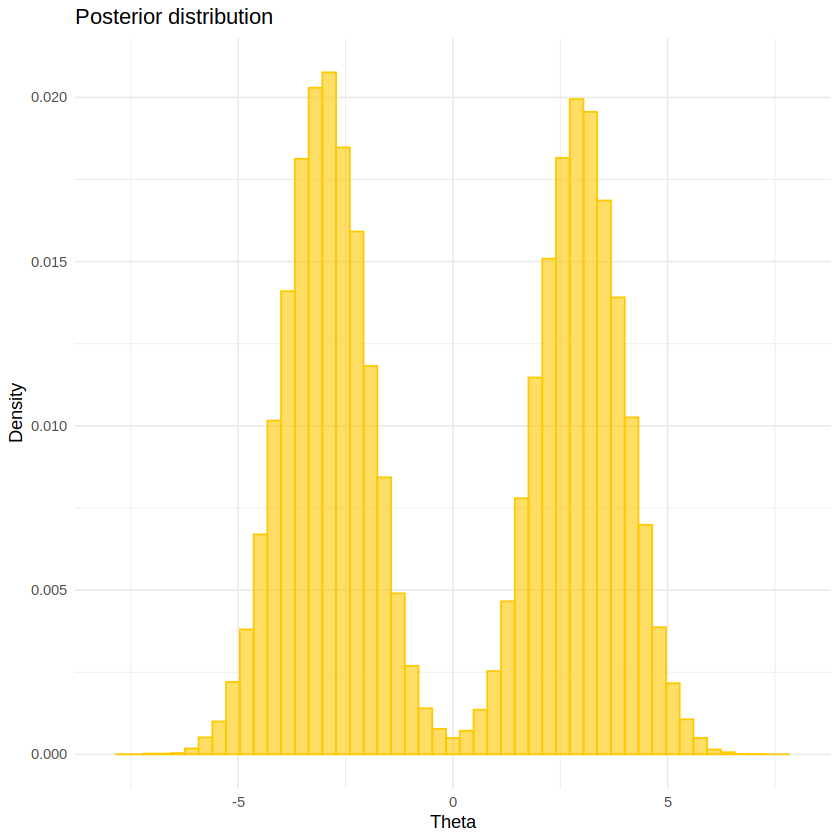

Normalized effective size = 0.01612149 
#################################

Running with burn_in = 20000 and thinning = 10 


Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_bar()`).”


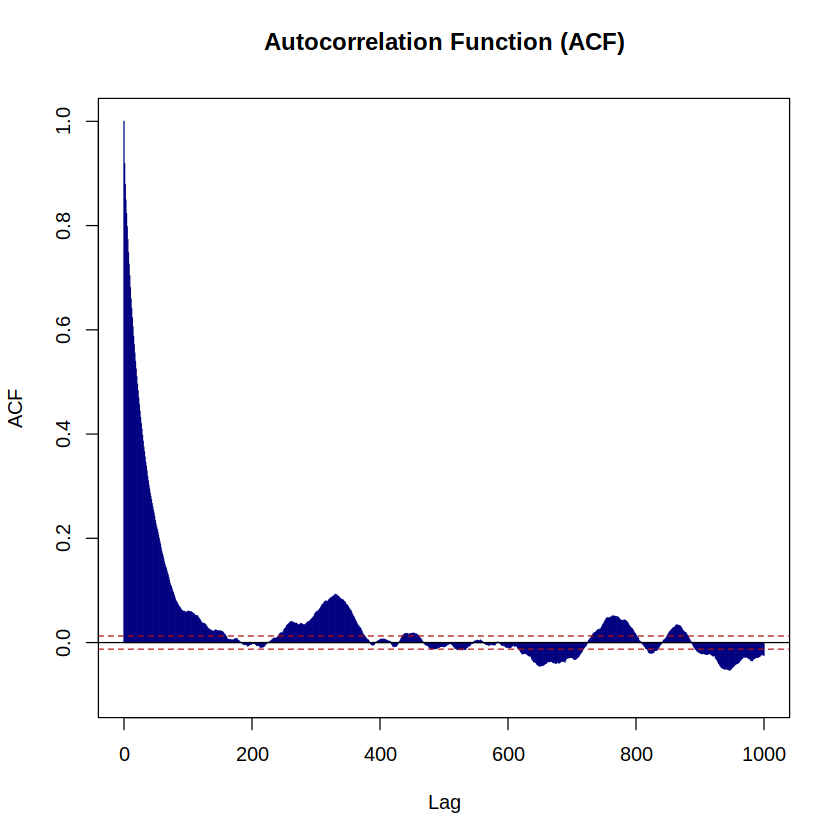

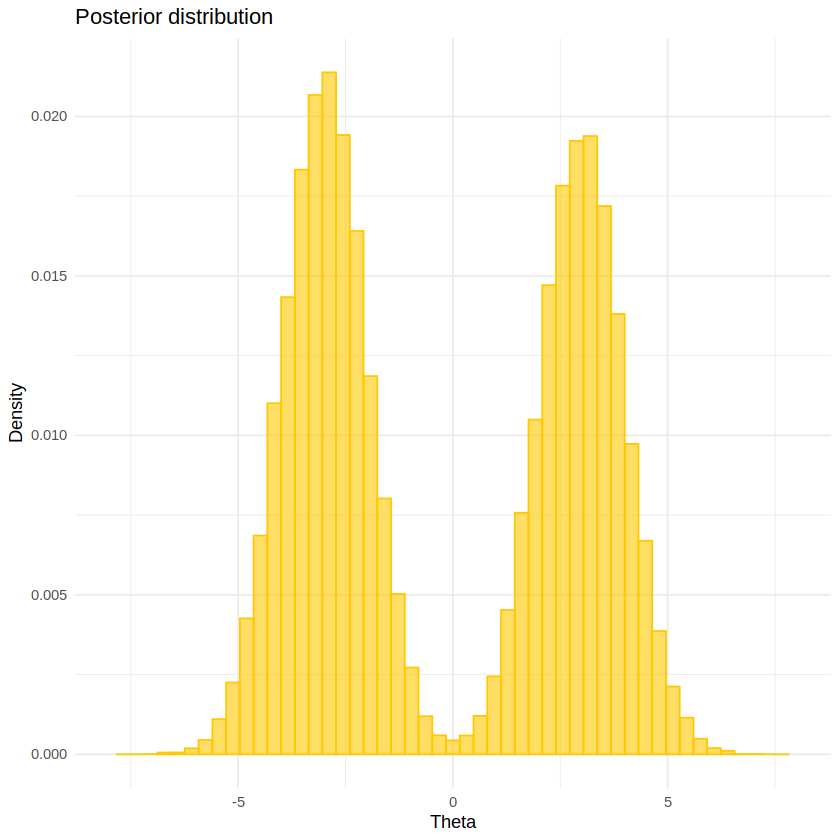

Normalized effective size = 0.03266324 
#################################

Running with burn_in = 20000 and thinning = 15 


Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_bar()`).”


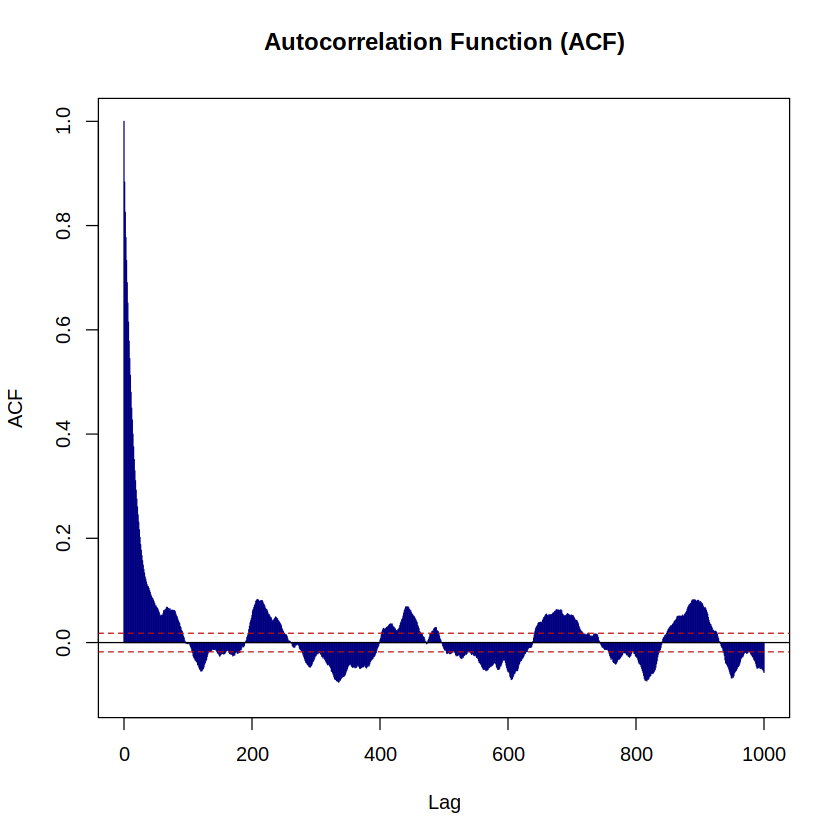

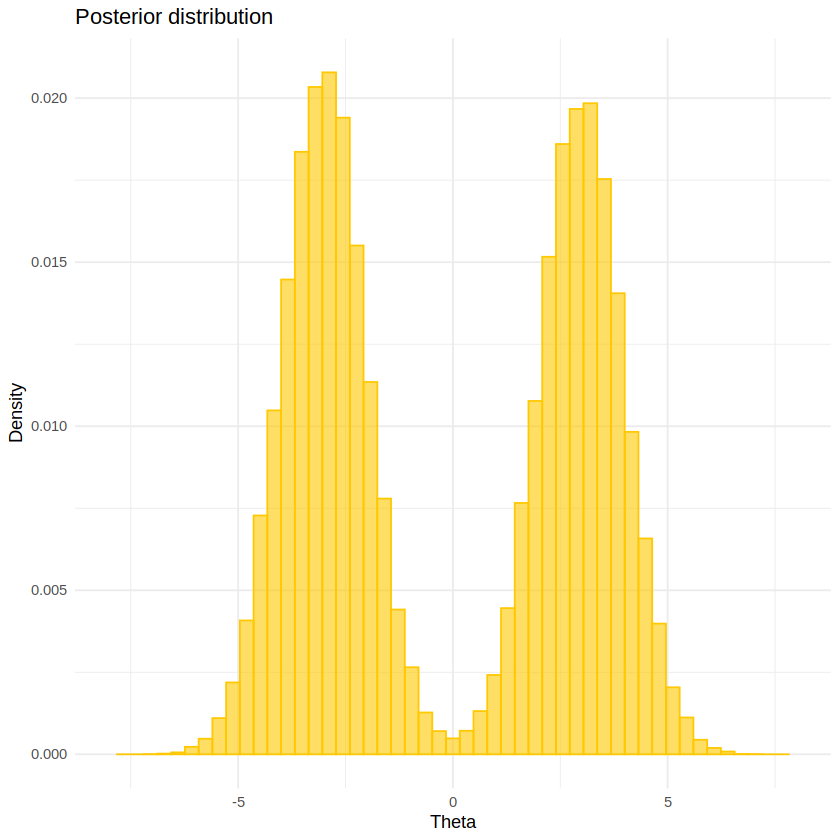

Normalized effective size = 0.04742704 
#################################

Running with burn_in = 20000 and thinning = 20 


Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_bar()`).”


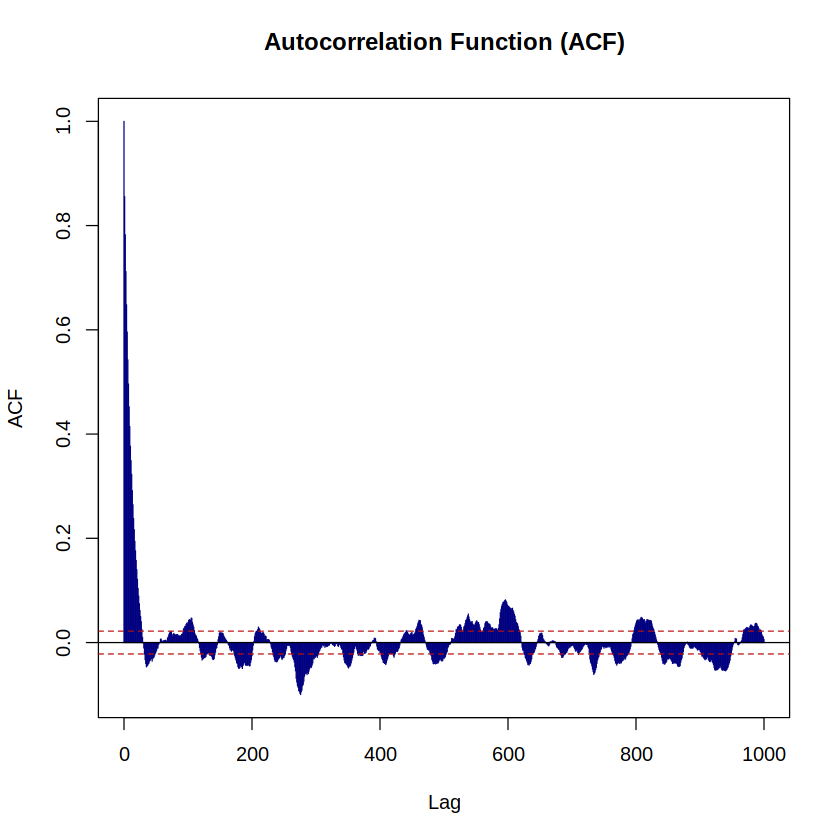

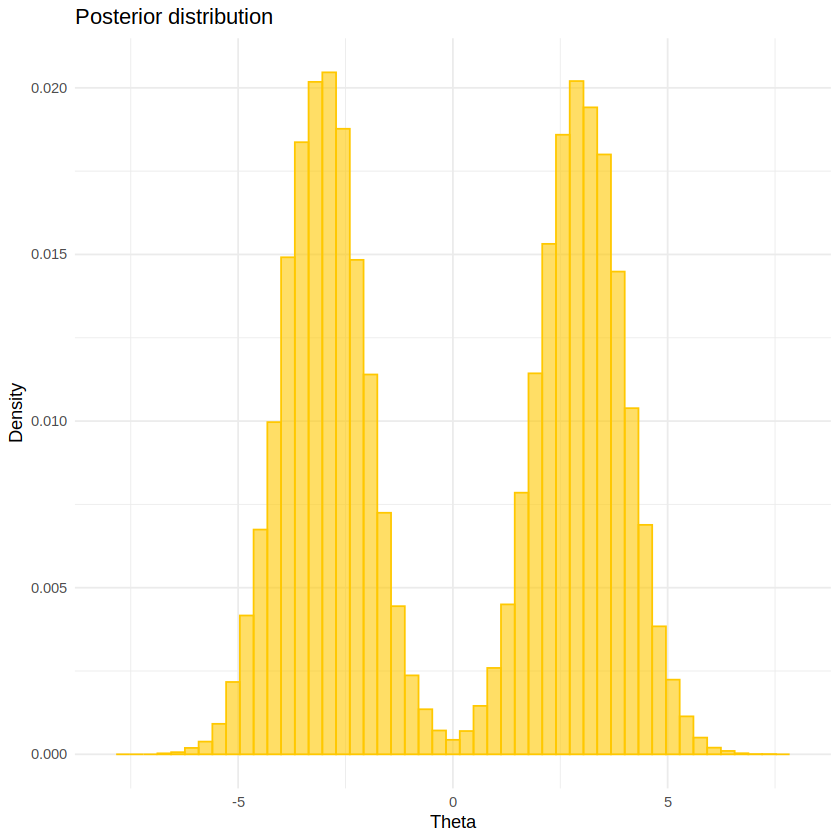

Normalized effective size = 0.06253786 
#################################

Running with burn_in = 30000 and thinning = 1 


Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_bar()`).”


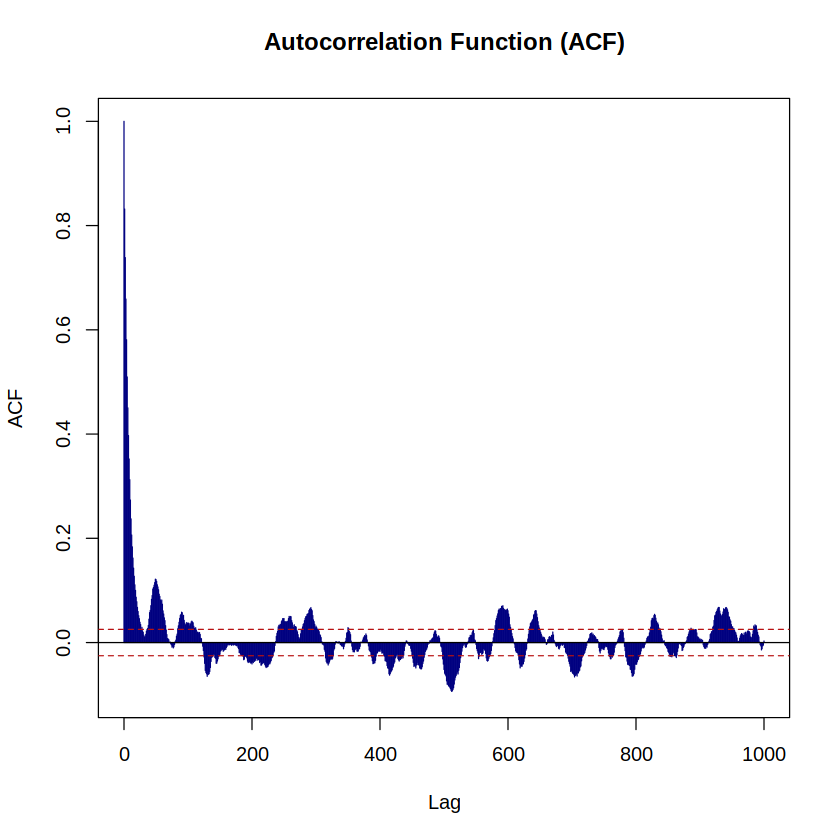

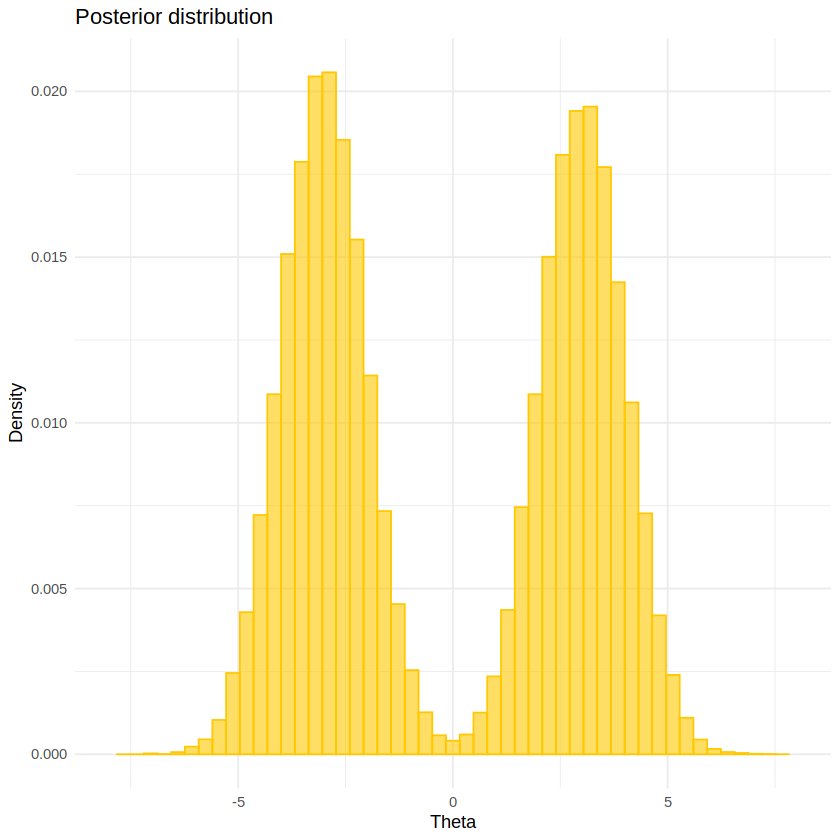

Normalized effective size = 0.003187454 
#################################

Running with burn_in = 30000 and thinning = 5 


Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_bar()`).”


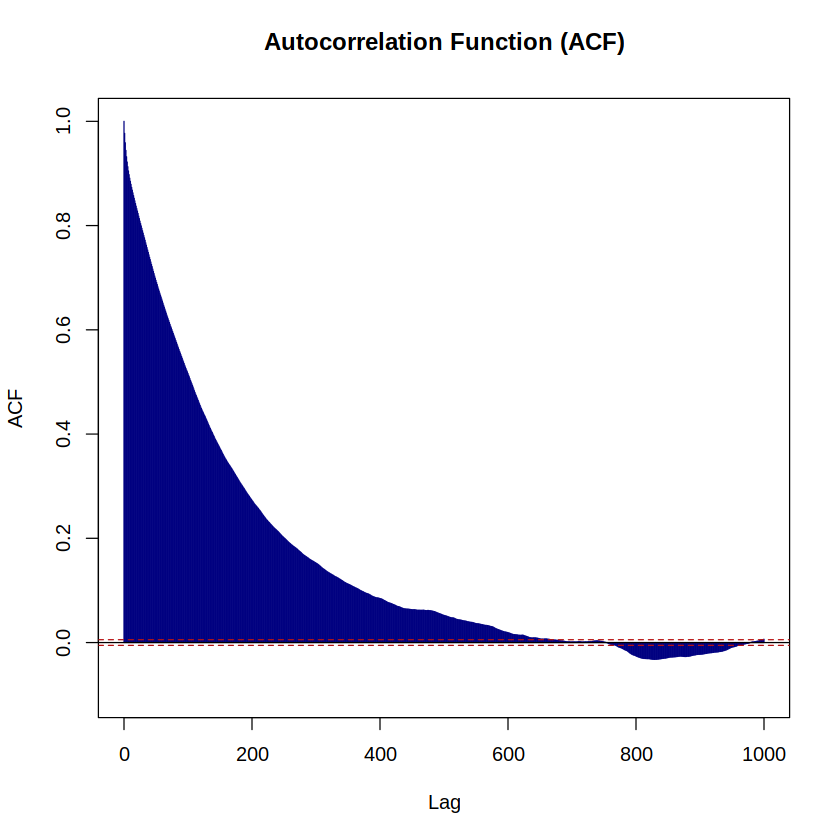

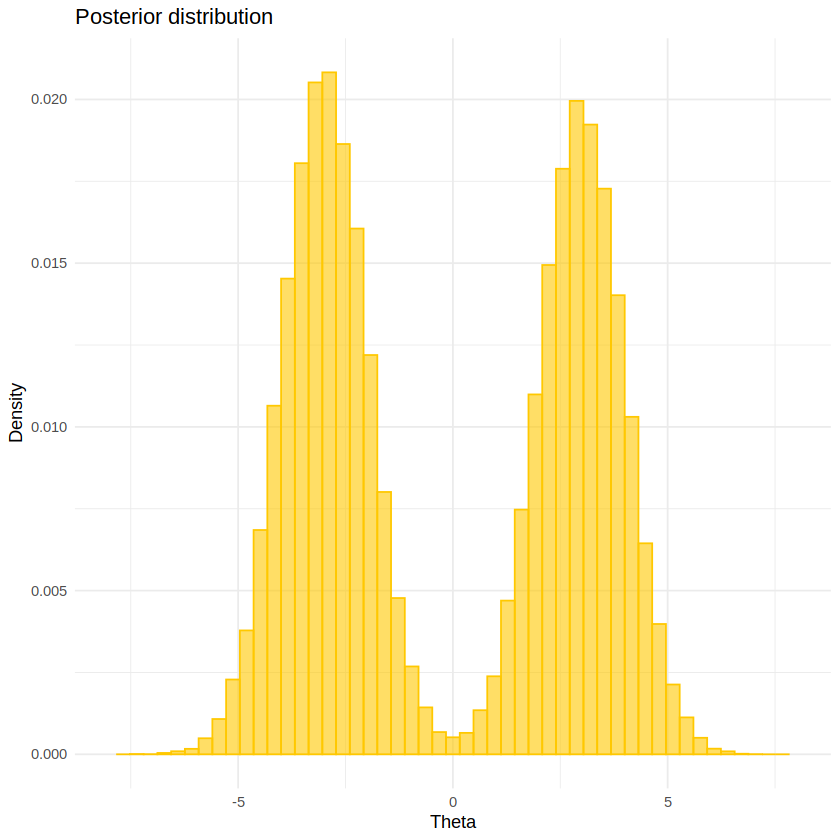

Normalized effective size = 0.01650106 
#################################

Running with burn_in = 30000 and thinning = 10 


Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_bar()`).”


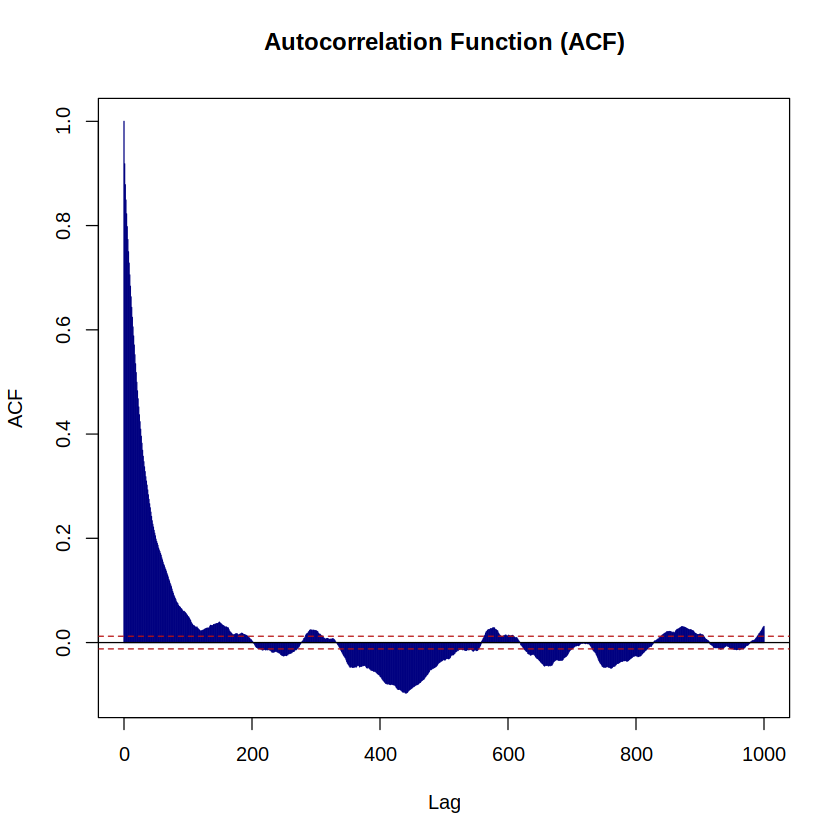

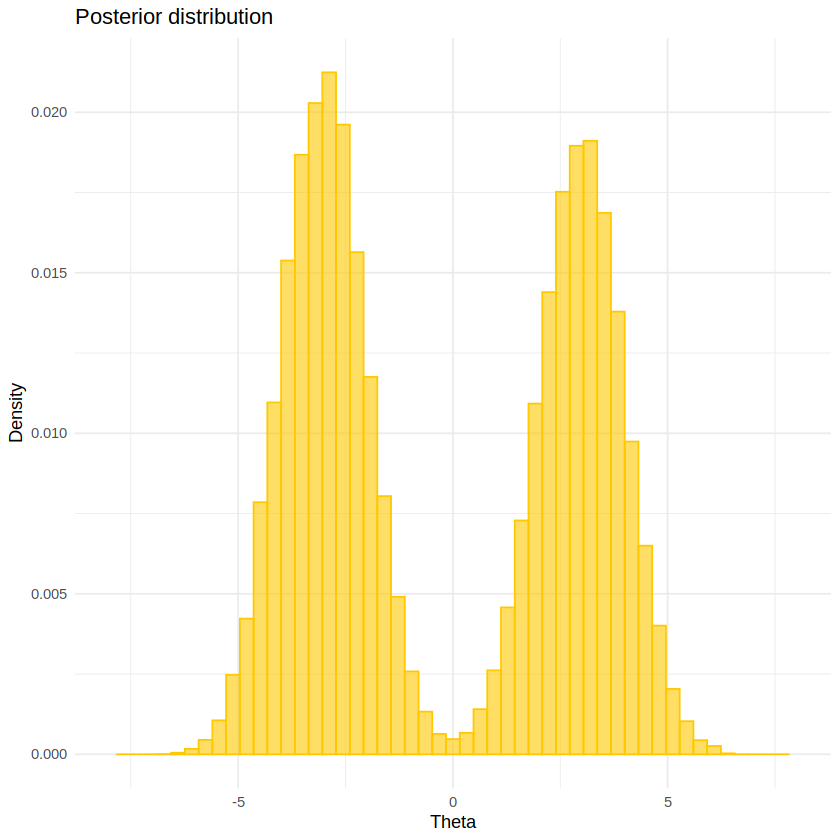

Normalized effective size = 0.03318509 
#################################

Running with burn_in = 30000 and thinning = 15 


Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_bar()`).”


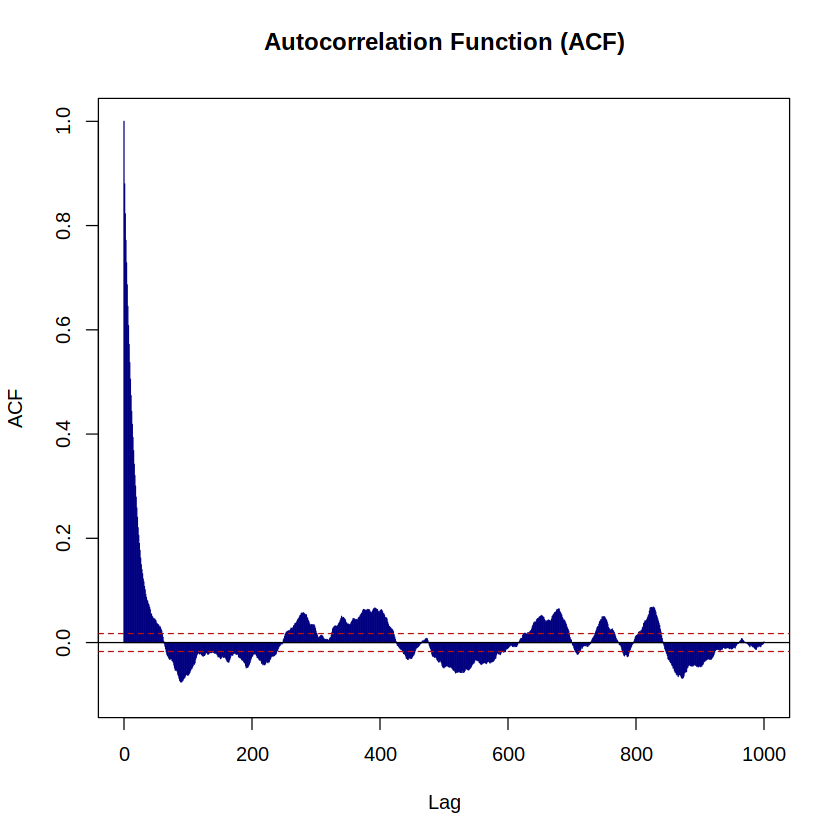

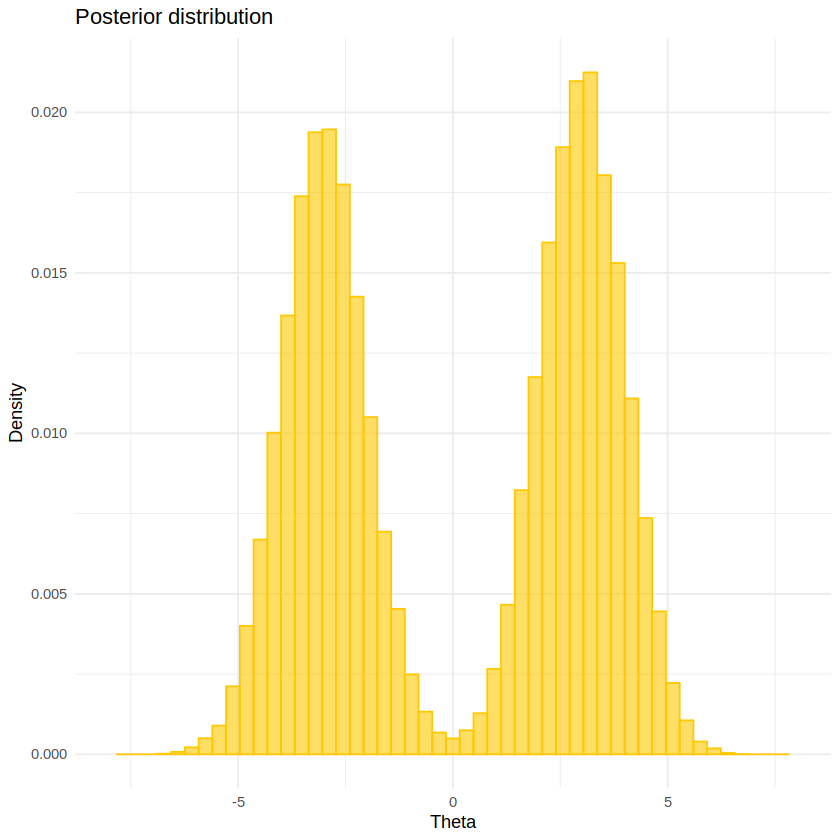

Normalized effective size = 0.05619972 
#################################

Running with burn_in = 30000 and thinning = 20 


Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_bar()`).”


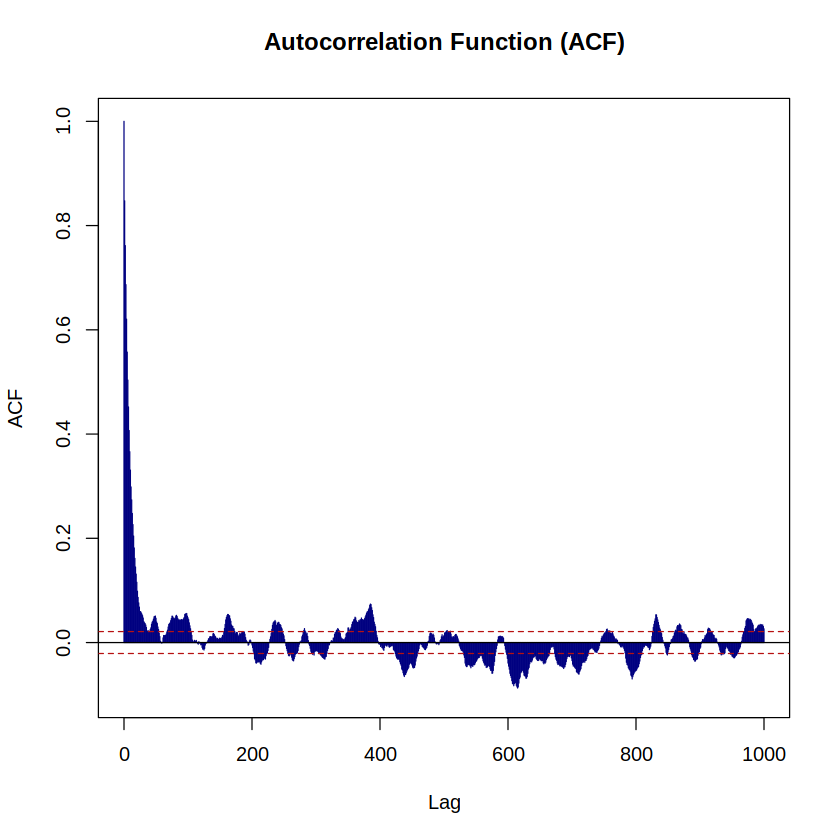

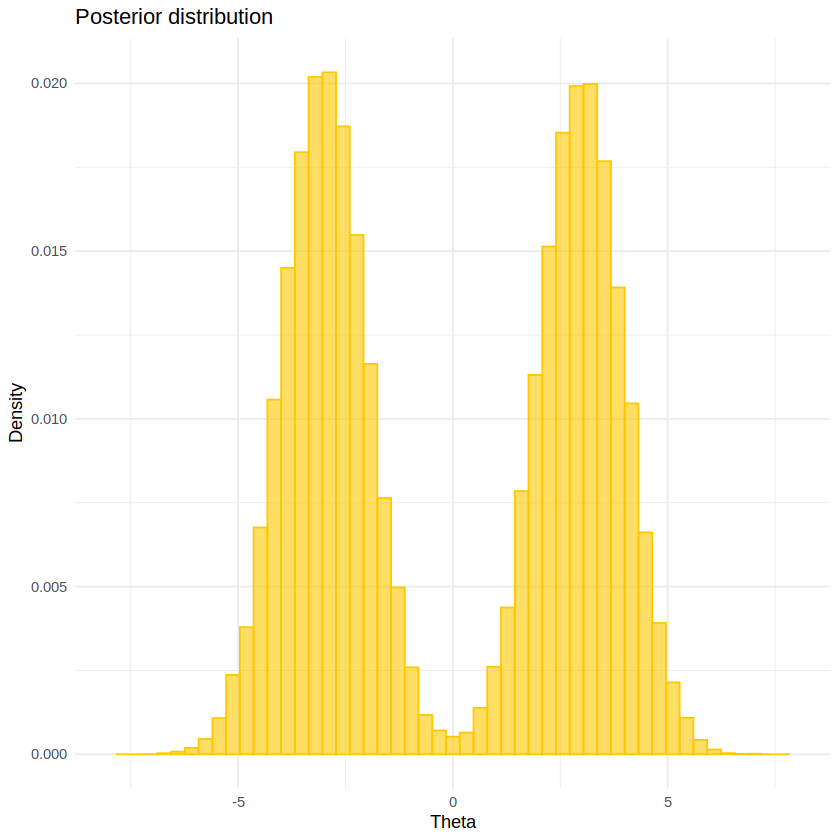

Normalized effective size = 0.06497676 
#################################

Running with burn_in = 40000 and thinning = 1 


Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_bar()`).”


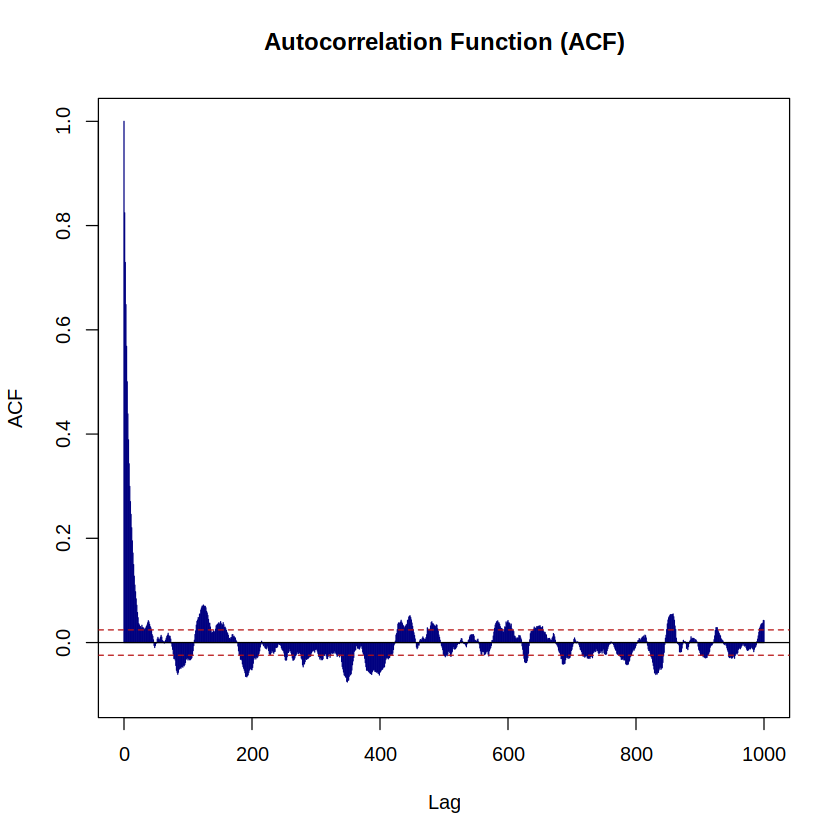

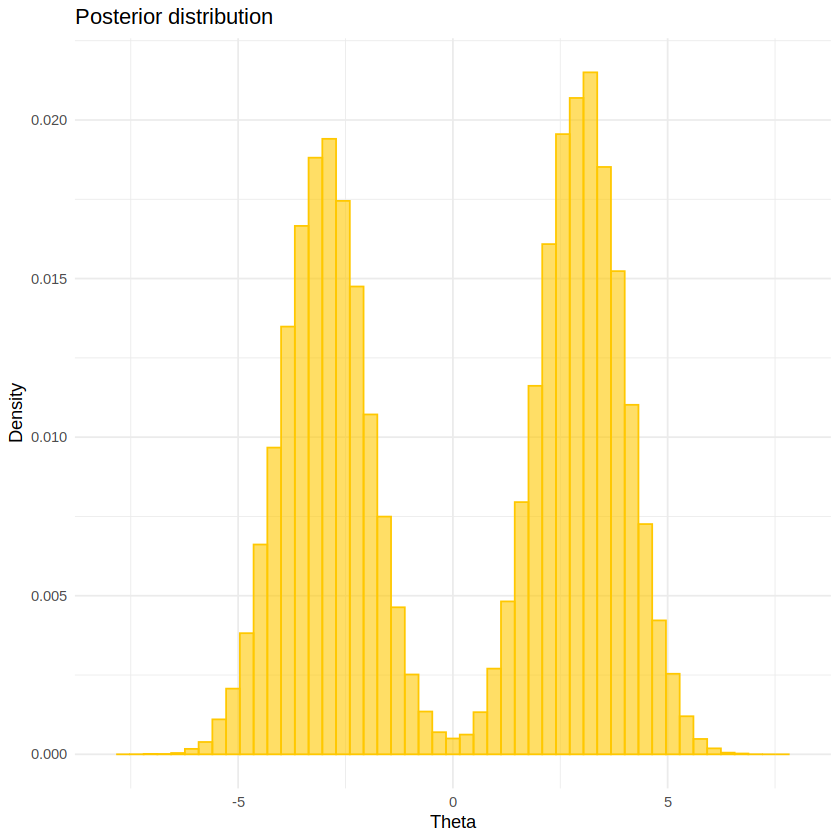

Normalized effective size = 0.003484423 
#################################

Running with burn_in = 40000 and thinning = 5 


Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_bar()`).”


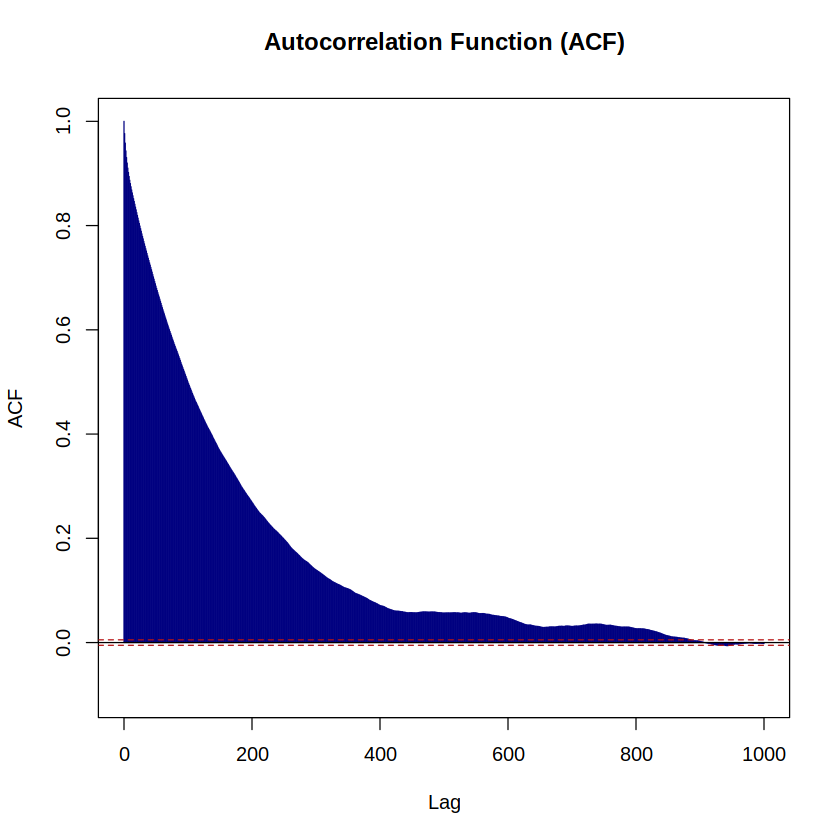

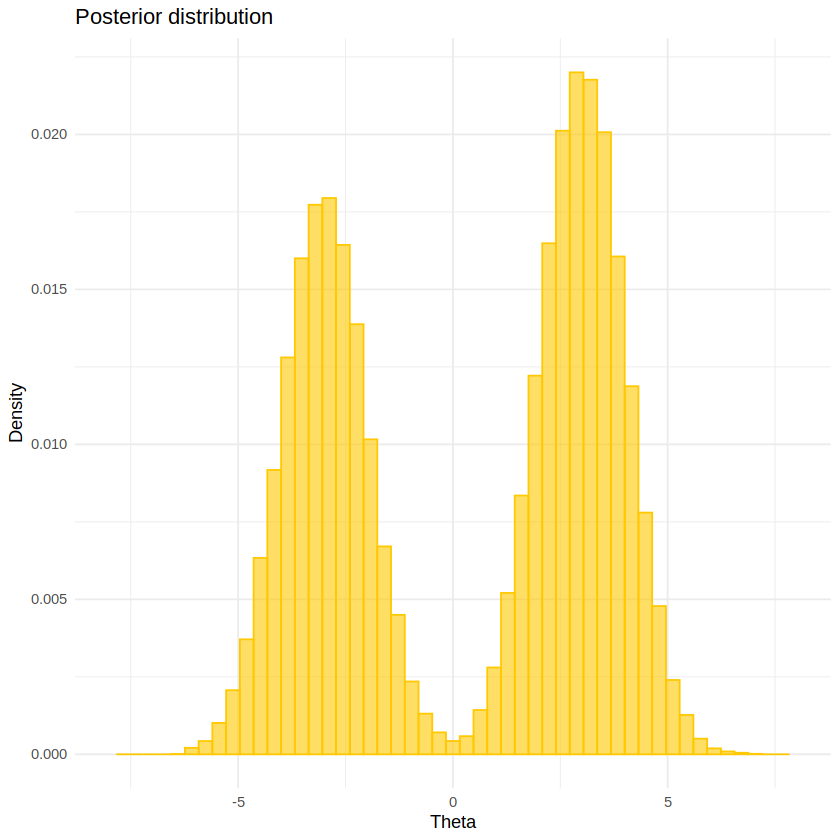

Normalized effective size = 0.01741891 
#################################

Running with burn_in = 40000 and thinning = 10 


Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_bar()`).”


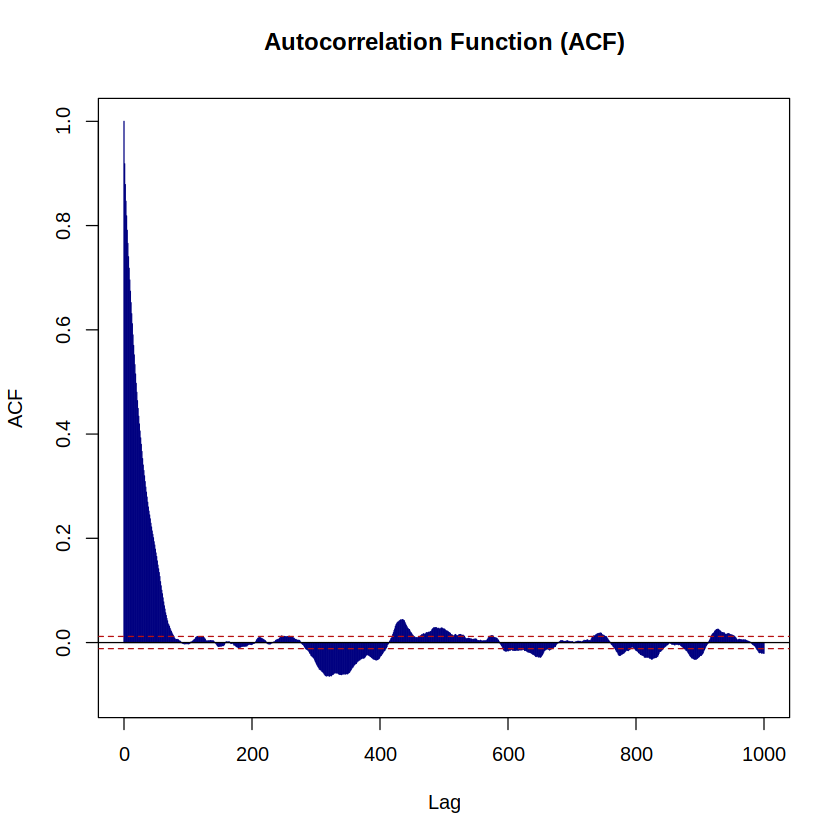

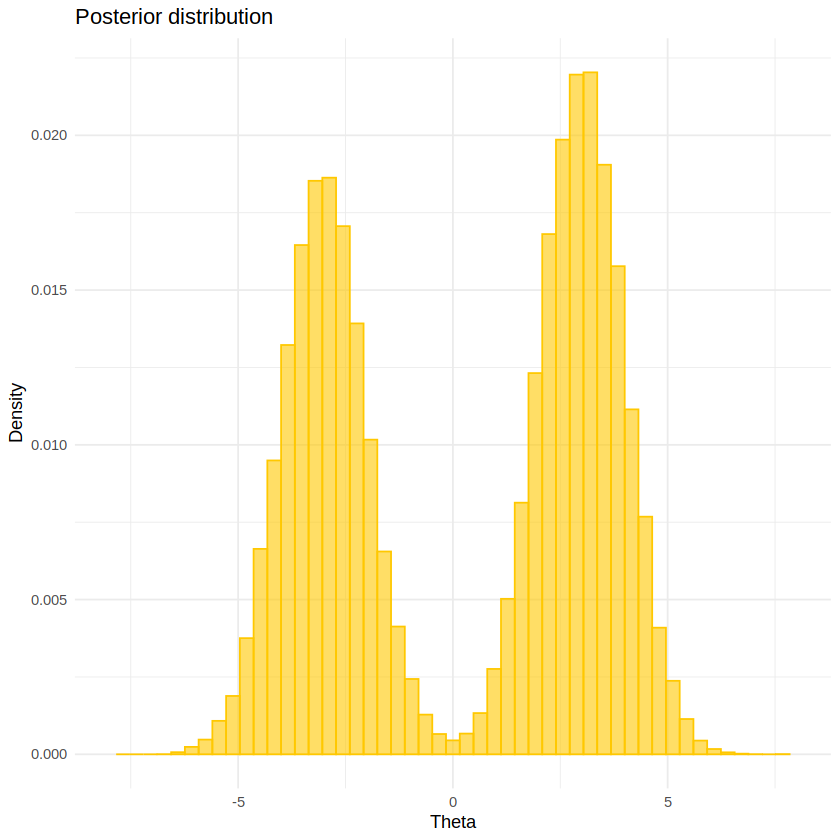

Normalized effective size = 0.03337114 
#################################

Running with burn_in = 40000 and thinning = 15 


Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_bar()`).”


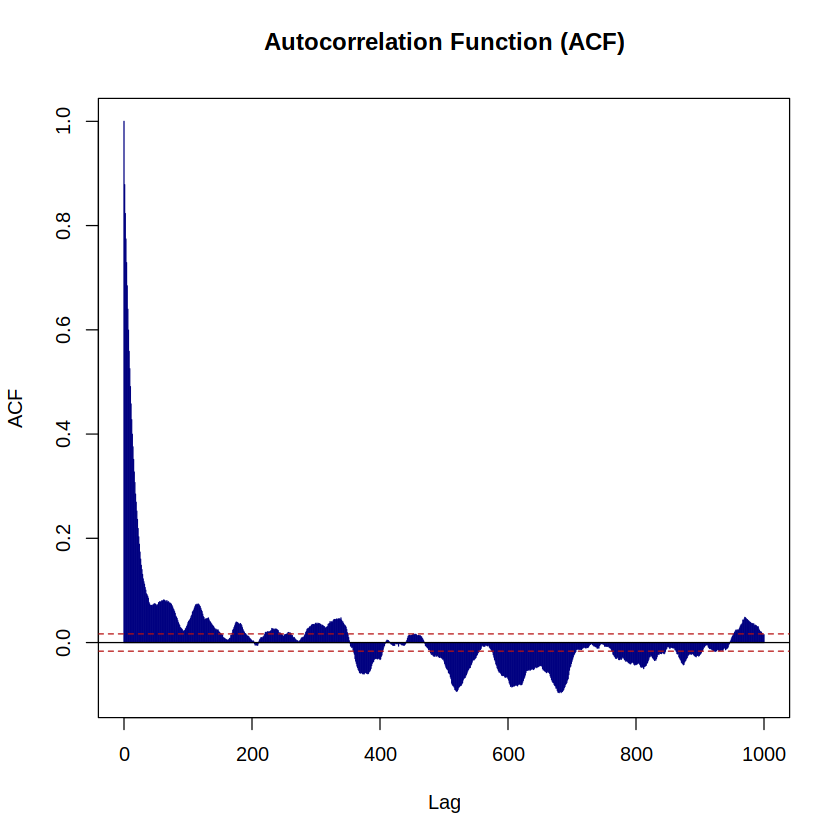

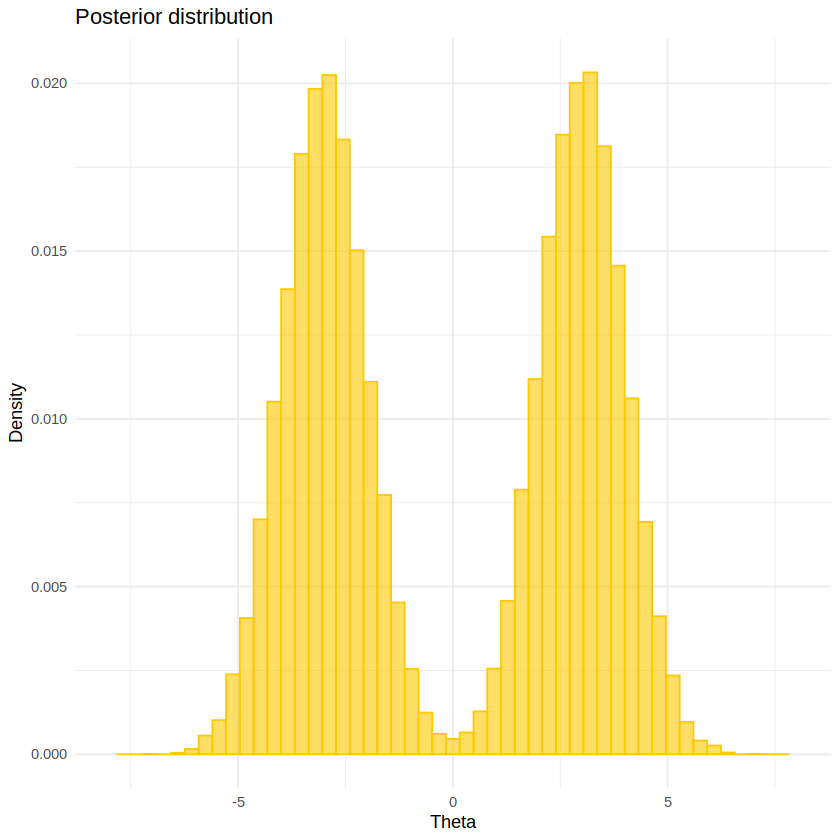

Normalized effective size = 0.05182418 
#################################

Running with burn_in = 40000 and thinning = 20 


Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_bar()`).”


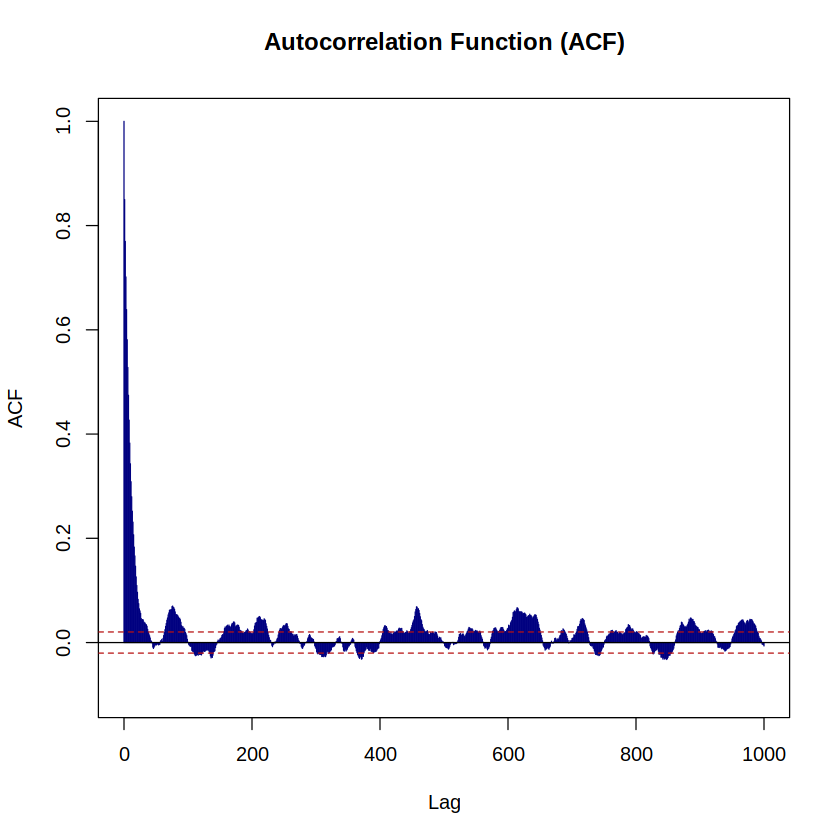

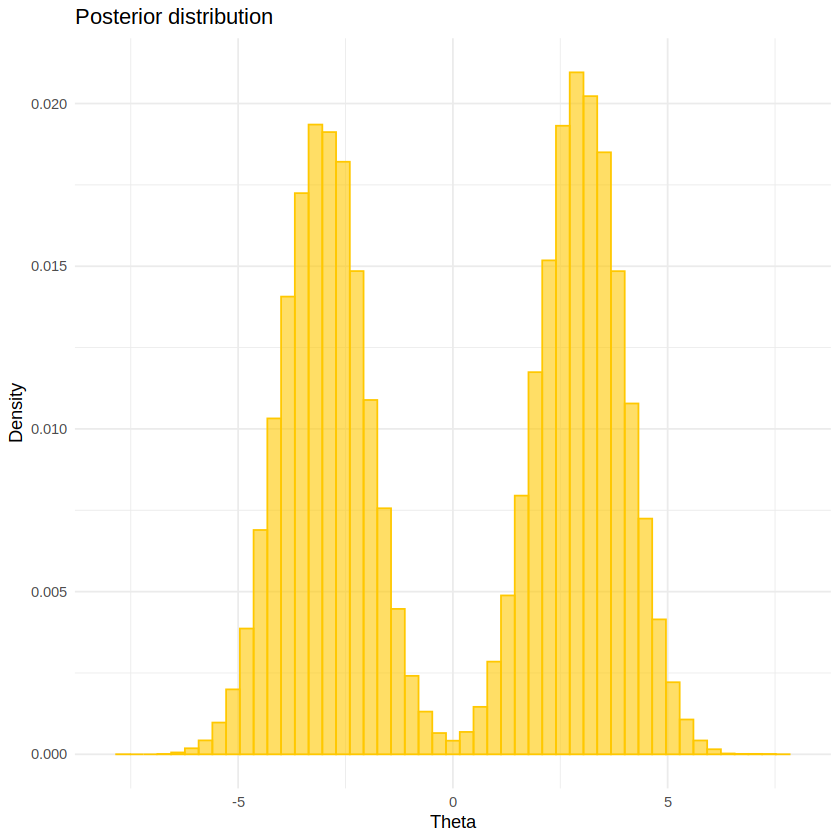

Normalized effective size = 0.0632682 
#################################

Running with burn_in = 50000 and thinning = 1 


Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_bar()`).”


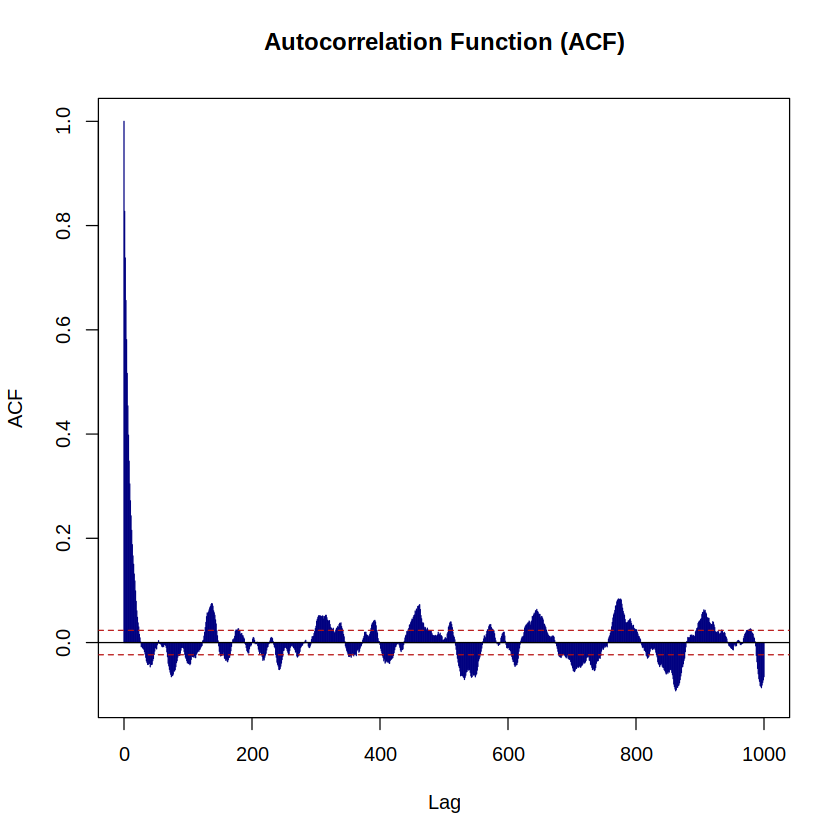

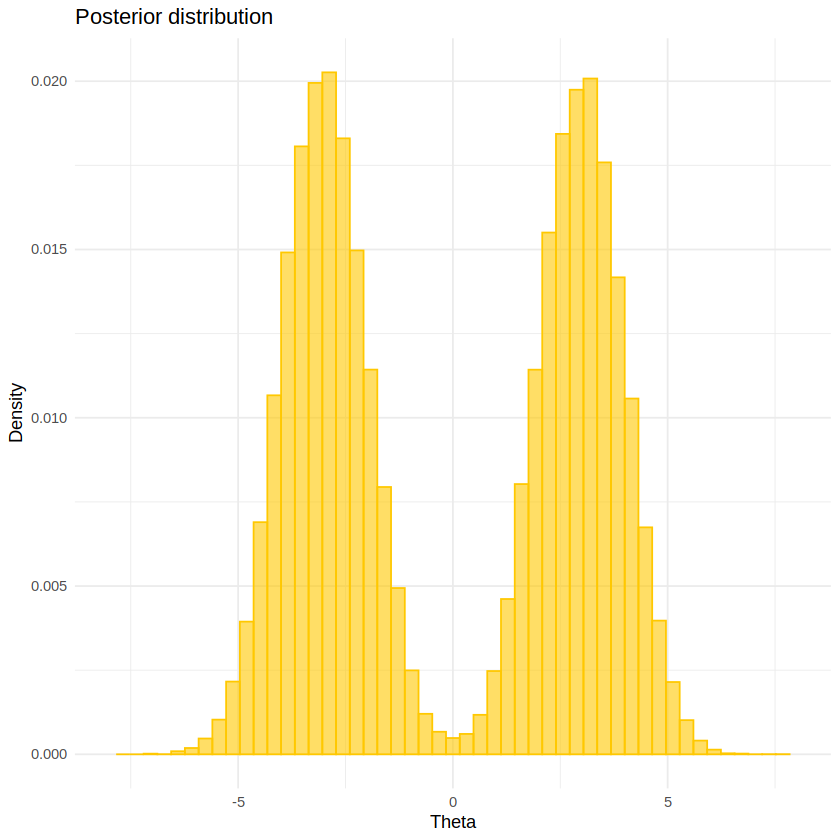

Normalized effective size = 0.003305917 
#################################

Running with burn_in = 50000 and thinning = 5 


Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_bar()`).”


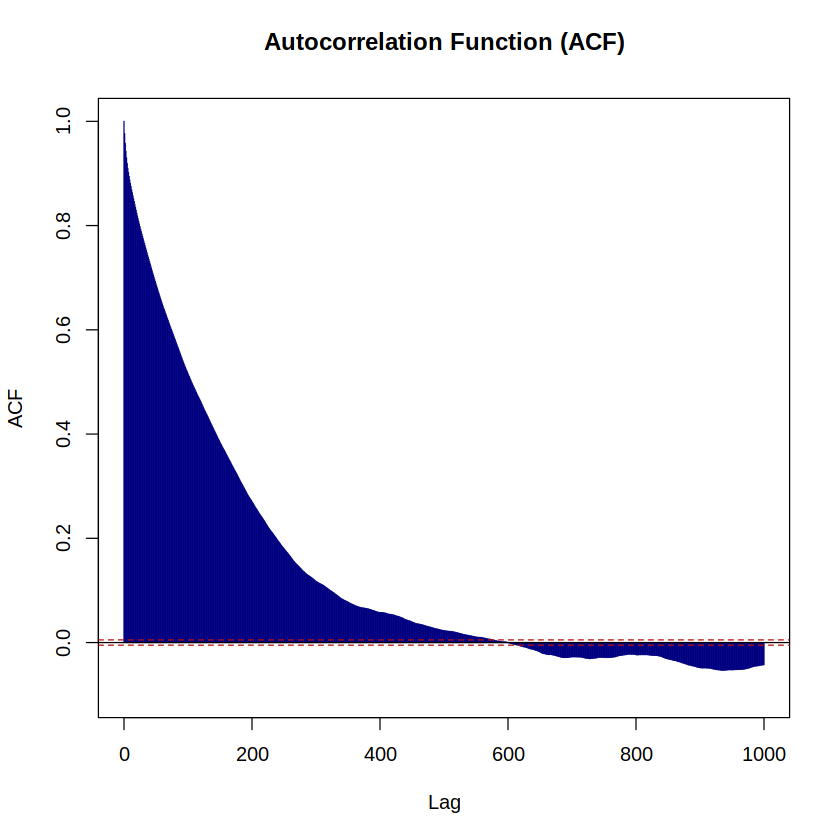

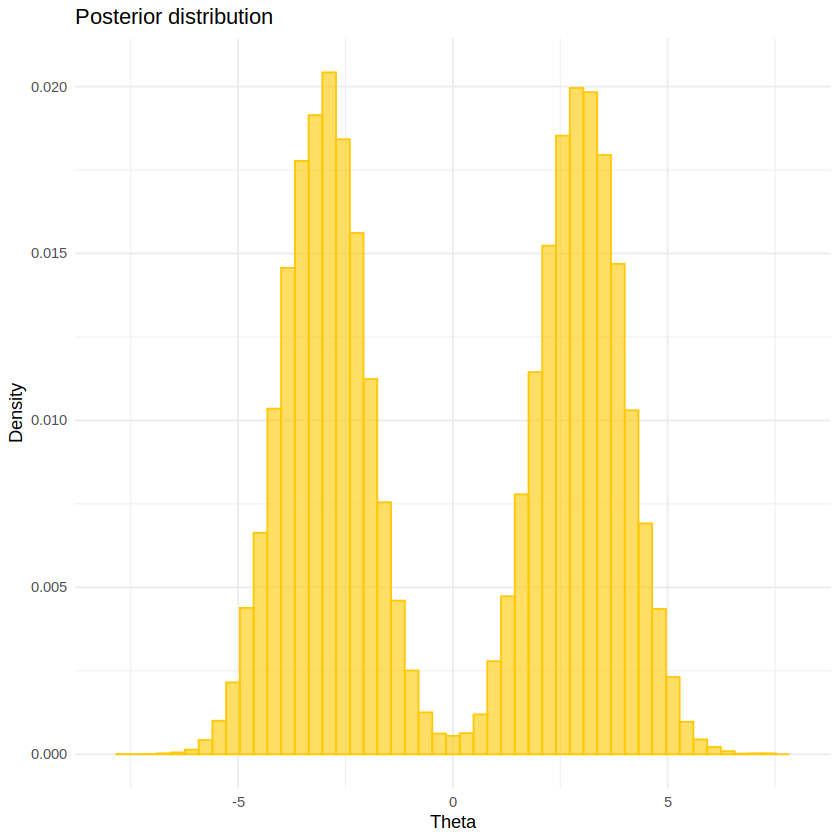

Normalized effective size = 0.01723159 
#################################

Running with burn_in = 50000 and thinning = 10 


Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_bar()`).”


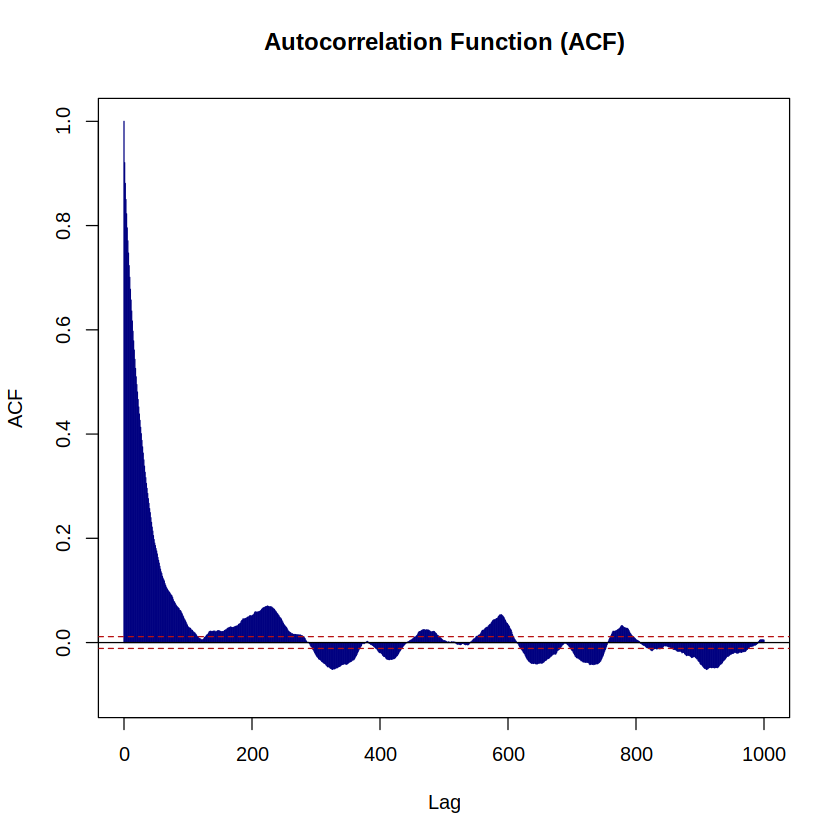

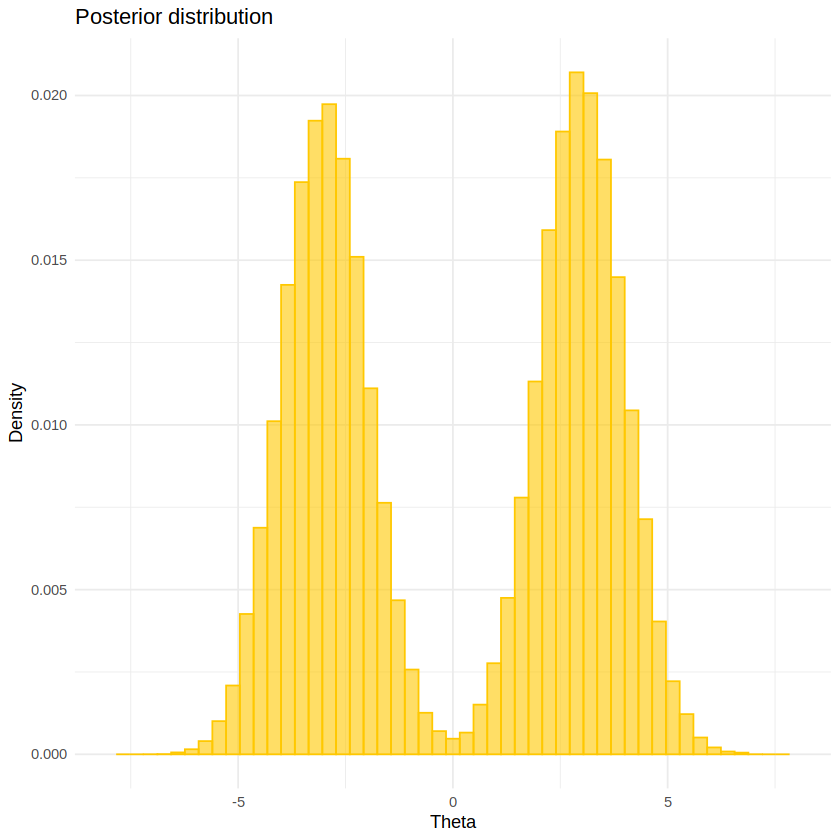

Normalized effective size = 0.03106268 
#################################

Running with burn_in = 50000 and thinning = 15 


Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_bar()`).”


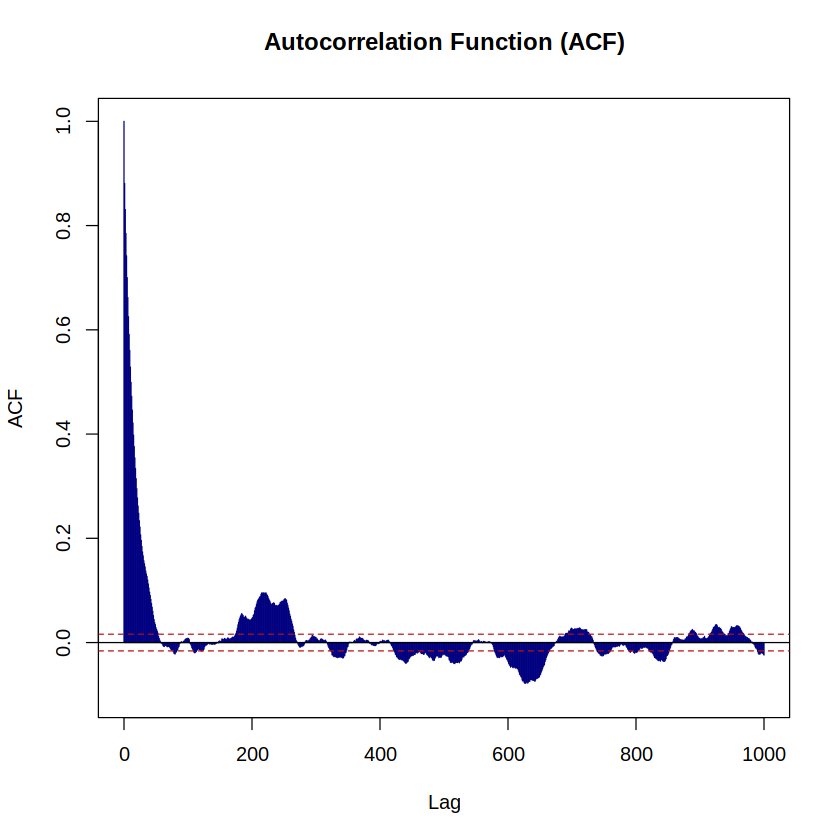

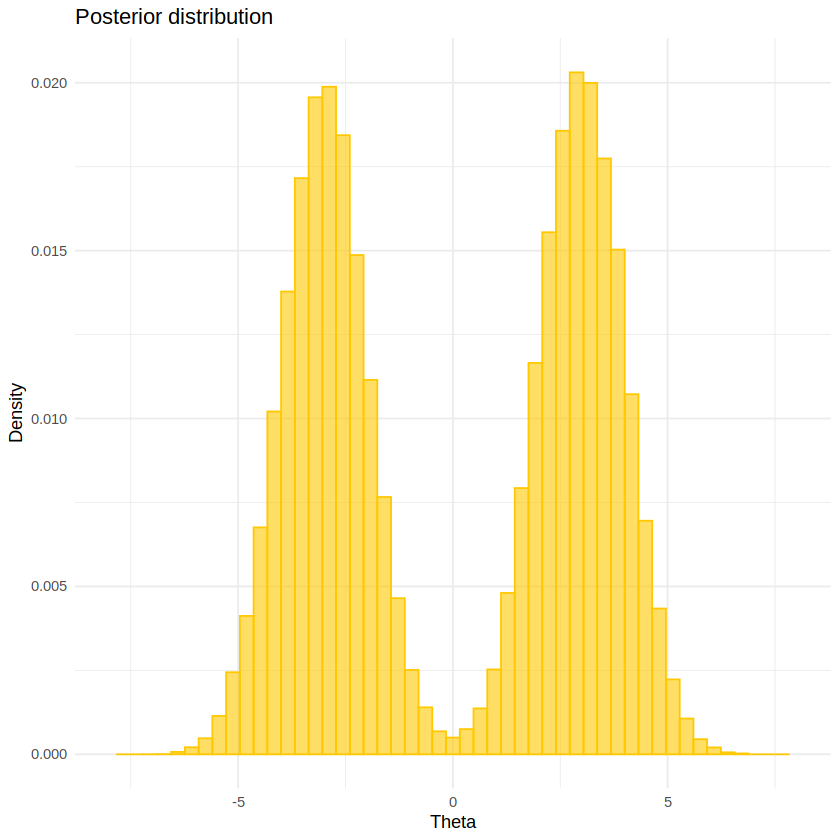

Normalized effective size = 0.05347293 
#################################

Running with burn_in = 50000 and thinning = 20 


Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_bar()`).”


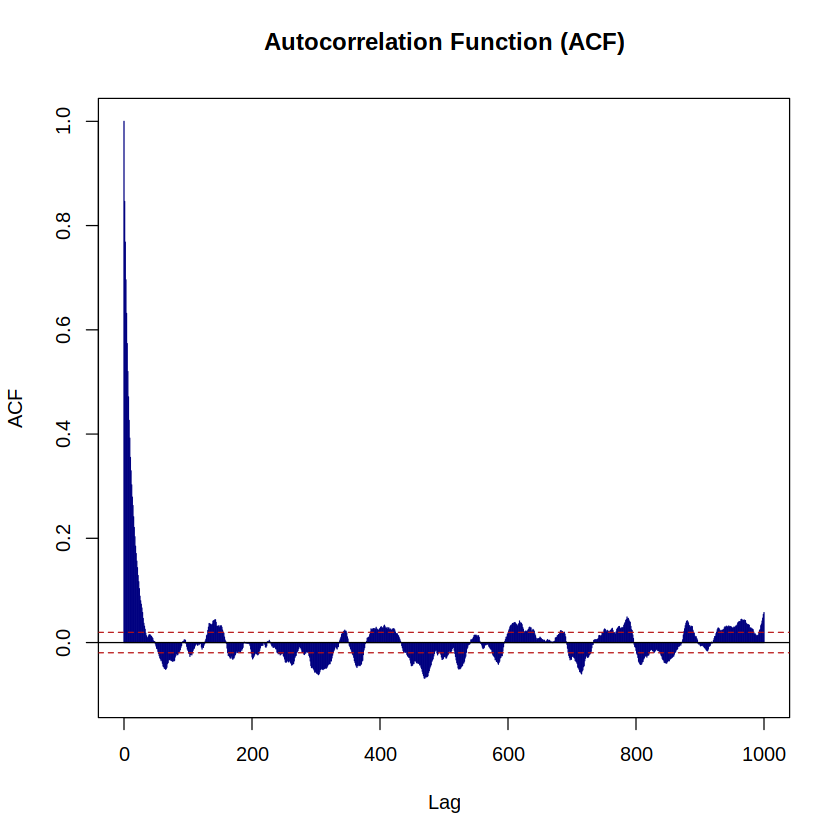

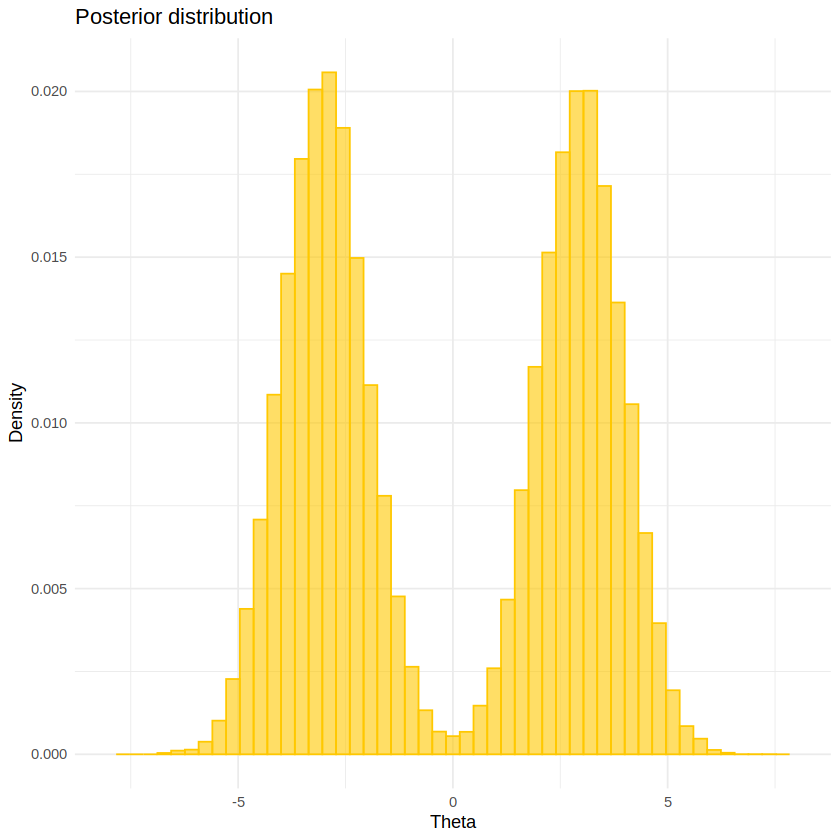

Normalized effective size = 0.06618866 
#################################



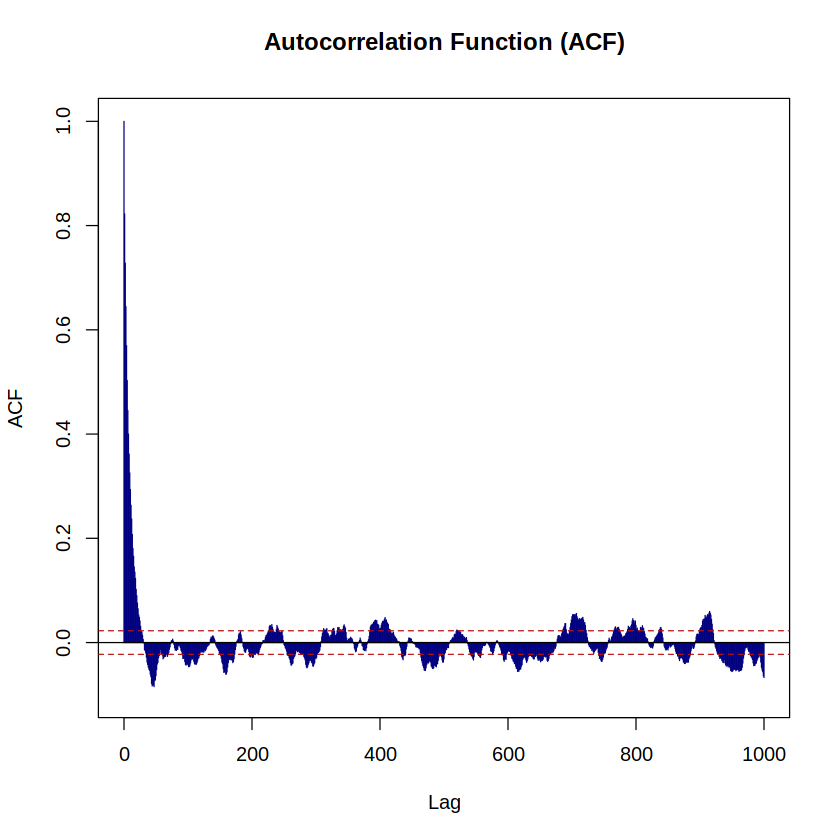

In [7]:
burn_in_values <- c(100, 1000, 5000, 10000, 20000, 30000, 40000, 50000)
thinning_values <- c(1, 5, 10, 15, 20)
lag_max <- 1000
n_sample <- 100000
n_bins <- 50

effective_sizes <- list()

effective_sizes <- data.frame(burn_in = integer(), thinning = integer(),
                              eff_size = numeric())

for (burn_in in burn_in_values) {
  for (thinning in thinning_values) {
    cat("Running with burn_in =", burn_in, "and thinning =", thinning, "\n")

    random_theta <- rnorm(1, 0, 1)
    out <- metropolis_sampler(random_theta, n_sample, burn_in)
    plot_posterior(out$value, theta_values, post_values, n_bins)
    eff_size <- plot_acf(out, thinning, lag_max)

    cat("Normalized effective size =", eff_size, "\n")
    effective_sizes <- rbind(effective_sizes,
                             data.frame(burn_in = burn_in, thinning = thinning,
                                        eff_size = eff_size))

    cat("#################################\n\n")
  }
}

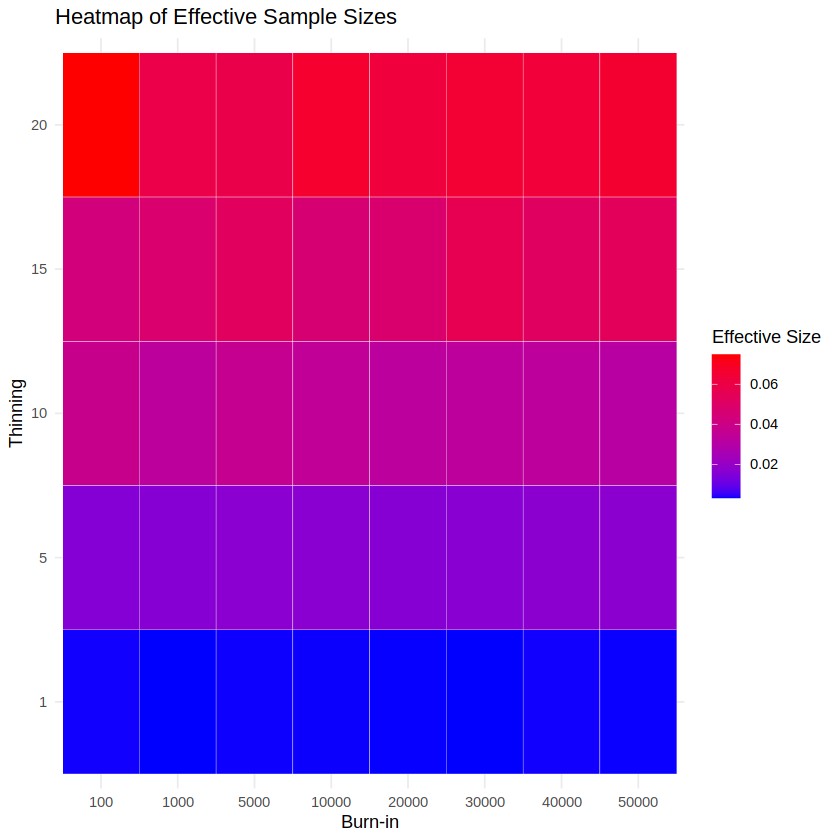

In [8]:
ggplot(effective_sizes, aes(x = as.factor(burn_in),
                            y = as.factor(thinning), fill = eff_size)) +
  geom_tile(color = "white") +
  scale_fill_gradient(low = "blue", high = "red") +
  labs(title = "Heatmap of Effective Sample Sizes",
       x = "Burn-in", y = "Thinning", fill = "Effective Size") +
  theme_minimal()

In [32]:
min_eff_size_row <- effective_sizes[effective_sizes$eff_size ==
                                      min(effective_sizes$eff_size), ]

min_burn_in <- min_eff_size_row$burn_in
min_thinning <- min_eff_size_row$thinning

cat("Best Effective Size (%):", min(effective_sizes$eff_size), "\n")
cat("Best Effective Size over 100000 samples:",
    min(effective_sizes$eff_size) * n_sample / min_thinning, "\n")
cat("Best Burn-in:", min_burn_in, "\n")
cat("Best Thinning:", min_thinning, "\n")


Best Effective Size (%): 0.003176671 
Best Effective Size over 100000 samples: 317.6671 
Best Burn-in: 1000 
Best Thinning: 1 


# Exercise 2

A set of measured data should follow, according to the physics model applied to them, a linear behavior. Data are the following:

$
\left\{ (X, Y) \right\} = \left\{(5, -7.821); (6, -1.494); (7, -15.444); (8, -10.807), (9, -13.735), (10, -14.442), (11, -15.892), (12, -18.326) \right\}
$

- Perform a simple linear regression model running a Markov Chain Monte Carlo with JAGS, assuming that data follow the model: $ Z[i] = a + b * X[i] $ 
- The likelihood of the measured data follow a Gaussian likelihood distribution: $Y[i] \sim \text{dnorm}(Z[i], \: c)$
- You can constrain the parameter a, b and c to the following intervals: $a \in [1,10]$, $b \in [−1,3]$ and $c \in [0.034,4]$ 
- Run JAGS experimenting with the burnin and number of iterations of the chain. Plot the evolution of the chains and the posterior distributions of a and b. Compute the 95% credibility interval for the parameters.
- Using the obtained posterior distributions, compute the posterior distribution of $\sigma = \frac{1}{\sqrt{c}}$

In [10]:
x <- c(5, 6, 7, 8, 9, 10, 11, 12)
y <- c(-7.821, -1.494, -15.444, -10.807, -13.735, -14.442, -15.892, -18.326)
data <- data.frame(X = x, Y = y)

In [11]:
model_string <- "
model { 
    # data likelihood 
    for (i in 1:length(Y)) { 
        Y[i] ~ dnorm(Z[i], c);
    } 
    
    # uniform priors for a, b, c 
    a ~ dunif(1, 10); 
    b ~ dunif(-1, 3); 
    c ~ dunif(0.034, 4); 
    
    # expected Z
    Z <- a + b * X
}
"

In [12]:
inits <- function() {
  list(a = runif(1, 1, 10), b = runif(1, -1, 3), c = runif(1, 0.034, 4))
}

In [13]:
model <- jags.model(textConnection(model_string), data = data,
                    inits = inits, n.chains = 3)

update(model, 2000) # burn-in
samples <- coda.samples(model, c("a", "b", "c"), n.iter = 10000)
summary(samples)

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 8
   Unobserved stochastic nodes: 3
   Total graph size: 36

Initializing model




Iterations = 3001:13000
Thinning interval = 1 
Number of chains = 3 
Sample size per chain = 10000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

      Mean       SD  Naive SE Time-series SE
a  1.47467 0.462494 2.670e-03      0.0061594
b -0.94762 0.050426 2.911e-04      0.0006462
c  0.04408 0.009417 5.437e-05      0.0001188

2. Quantiles for each variable:

      2.5%      25%      50%      75%    97.5%
a  1.01200  1.13943  1.33772  1.66540  2.70824
b -0.99866 -0.98453 -0.96276 -0.92660 -0.81276
c  0.03429  0.03716  0.04136  0.04821  0.06901


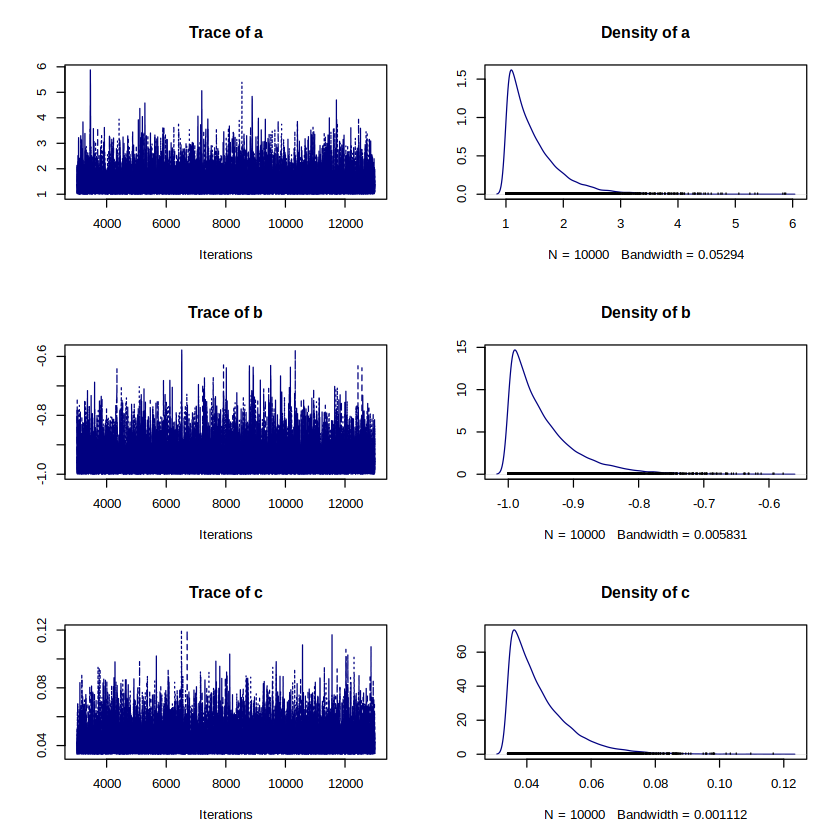

In [14]:
plot(samples, col = "navy")

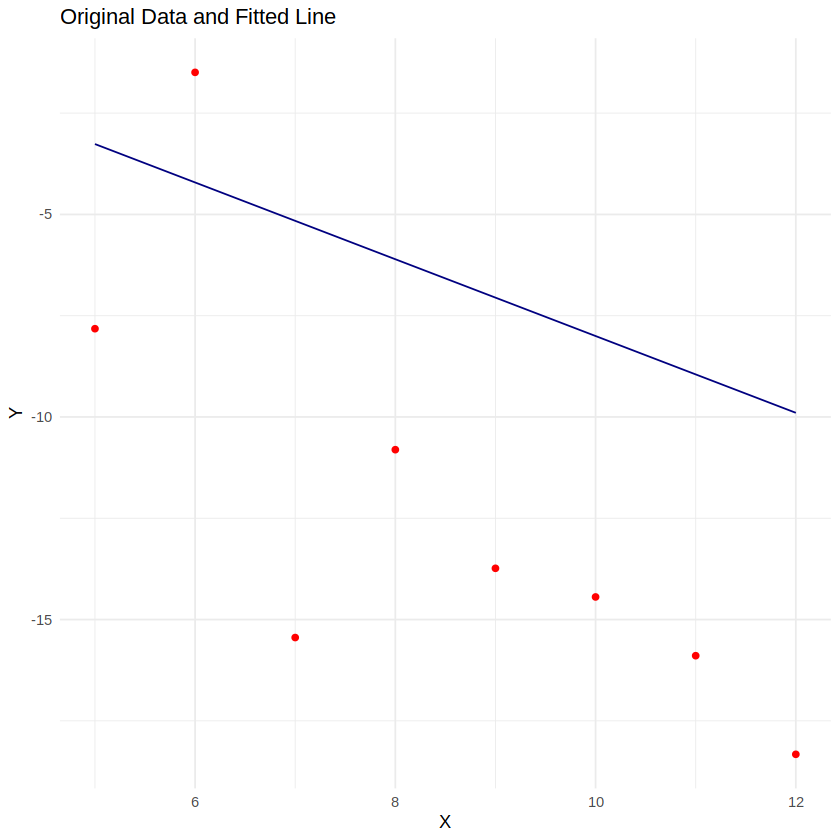

In [15]:
combined_samples <- do.call(rbind, samples)
fit_params <- colMeans(as.data.frame(combined_samples))

x_fit <- seq(min(data$X), max(data$X), by = 0.01)
y_fit <- fit_params["a"] + fit_params["b"] * x_fit

ggplot(data, aes(x = X, y = Y)) +
  geom_point(color = "red") +
  geom_line(data = data.frame(x_fit, y_fit),
            aes(x = x_fit, y = y_fit), color = "navy") +
  labs(title = "Original Data and Fitted Line",
       x = "X",
       y = "Y") +
  theme_minimal()

In [16]:
quantiles <- summary(samples)$quantiles
quantiles_95_percent <- as.data.frame(quantiles[, c("2.5%", "97.5%")])
cat("95% credibility intervals:\n\n")
print(quantiles_95_percent)

95% credibility intervals:

         2.5%       97.5%
a  1.01200301  2.70823832
b -0.99866301 -0.81276423
c  0.03429187  0.06901029


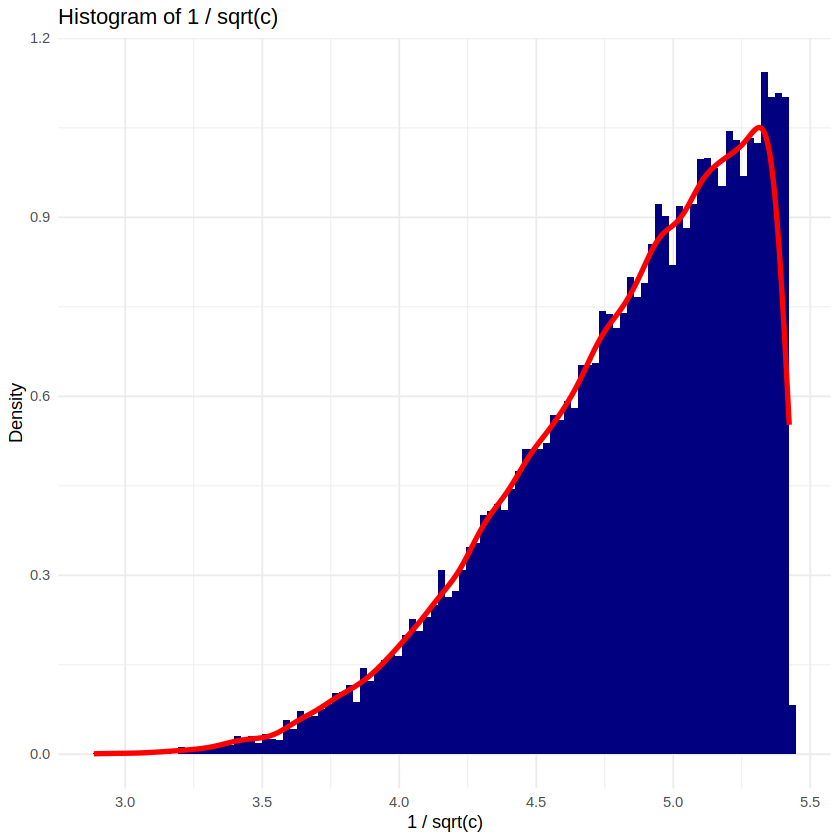

In [17]:
c_posterior <- as.data.frame(combined_samples)[["c"]]
sigma_posterior <- 1 / sqrt(c_posterior)

ggplot(data = data.frame(sigma_posterior), aes(x = sigma_posterior)) +
  geom_histogram(aes(y = after_stat(density)), bins = 100, fill = "navy") +
  geom_density(color = "red", linewidth = 1.5) +
  labs(title = "Histogram of 1 / sqrt(c)",
       x = "1 / sqrt(c)",
       y = "Density") +
  theme_minimal()

# Exercise 3

Suppose we observe the following values: $x = 2.06, 5.56, 7.93, 6.56, 205$ and we assume that the data come from a gaussian distribution with unknown mean $\mu$ and variance $\sigma ^ 2$.

- Build a simple JAGS model and run a Markov Chain Monte Carlo to obtain the posterior distribution of the mean and variance. 
- Assume uniform prior distributions for the parameters, $\mu \sim dunif(-10, 10)$ and $\sigma \sim dunif(0,50)$. 
- Compute also the posterior distribution for $\mu / \sigma$.

In [18]:
x <- c(2.06, 5.56, 7.93, 6.56, 205)
data <- list(X = x, N = length(x))

In [19]:
model_string <- "
model { 
    # data prediction
    for (i in 1:N) {
        X[i] ~ dnorm(mu, sigma^2);
    } 
    
    # uniform priors for mu, sigma 
    mu ~ dunif(-10, 10); 
    sigma ~ dunif(0, 50); 
}
"

In [20]:
inits <- function() {
  list(mu = runif(1, -10, 10), sigma = runif(1, 0, 50))
}

In [21]:
model <- jags.model(textConnection(model_string), data = data,
                    inits = inits, n.chains = 3)

update(model, 2000) # burn-in
samples <- coda.samples(model, c("mu", "sigma"), n.iter = 10000)
summary(samples)

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 5
   Unobserved stochastic nodes: 2
   Total graph size: 14

Initializing model




Iterations = 3001:13000
Thinning interval = 1 
Number of chains = 3 
Sample size per chain = 10000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

        Mean       SD  Naive SE Time-series SE
mu    1.0040 5.702403 3.292e-02      4.457e-02
sigma 0.0115 0.003403 1.965e-05      2.465e-05

2. Quantiles for each variable:

           2.5%       25%     50%     75%   97.5%
mu    -9.307081 -3.757099 1.52569 5.99024 9.60142
sigma  0.005443  0.009088 0.01129 0.01371 0.01866


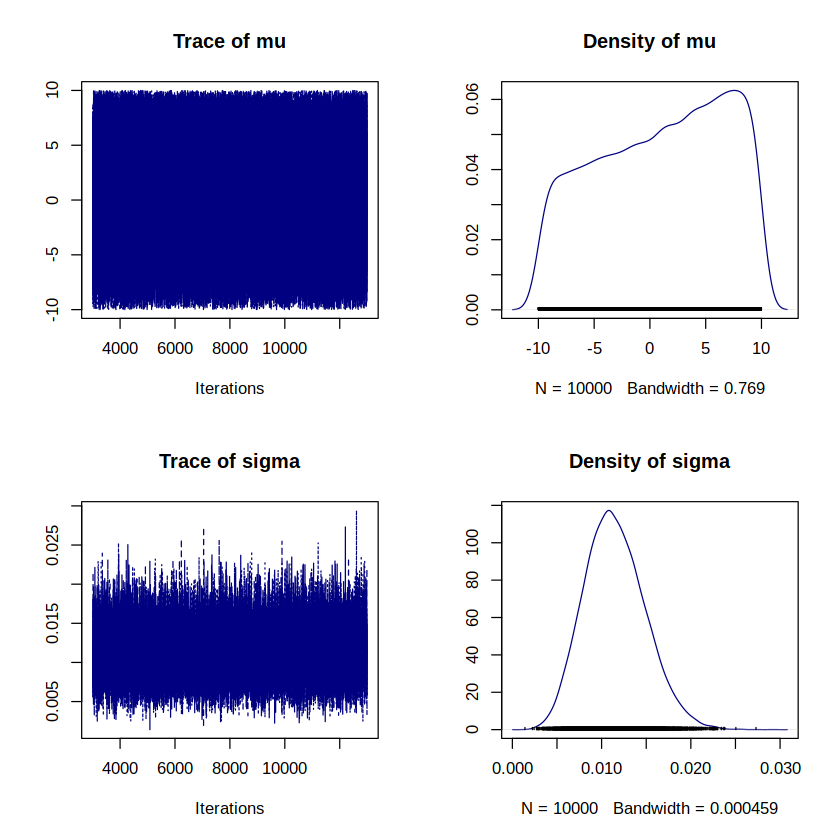

In [22]:
plot(samples, col = "navy")

Warning message:
“Removed 2 rows containing non-finite outside the scale range (`stat_bin()`).”
Warning message:
“Removed 2 rows containing non-finite outside the scale range
(`stat_density()`).”


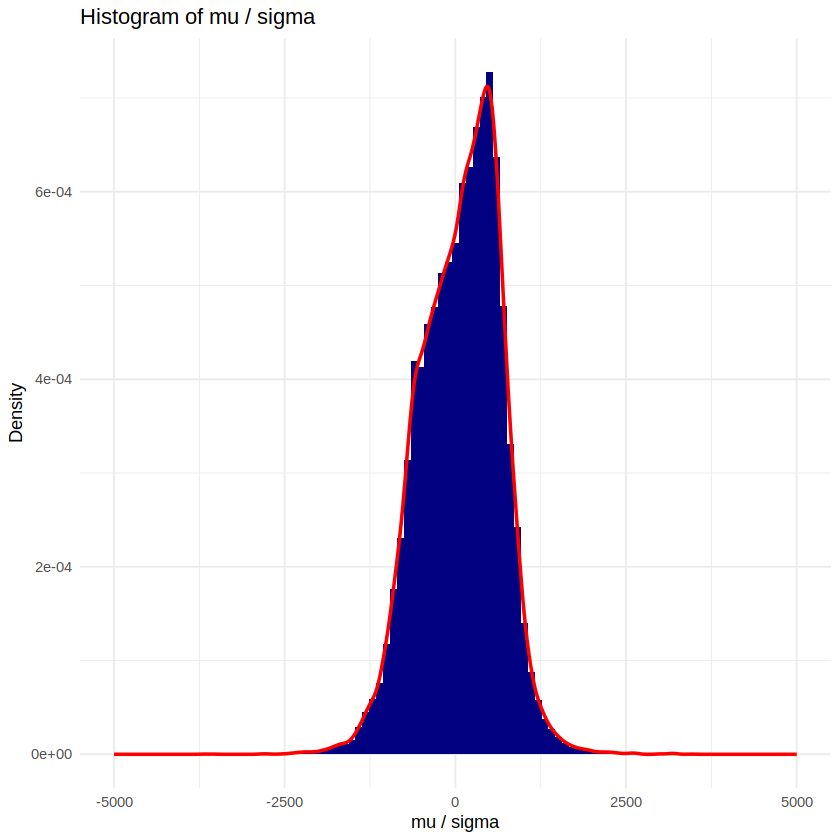

In [23]:
combined_samples <- do.call(rbind, samples)
mu_posterior <- as.data.frame(combined_samples)[["mu"]]
sigma_posterior <- as.data.frame(combined_samples)[["sigma"]]
mu_over_sigma <- mu_posterior / sigma_posterior

ggplot(data = data.frame(mu_over_sigma), aes(x = mu_over_sigma)) +
  geom_histogram(aes(y = after_stat(density)), bins = 100, fill = "navy") +
  geom_density(color = "red", linewidth = 1) +
  labs(title = "Histogram of mu / sigma",
       x = "mu / sigma",
       y = "Density") +
  xlim(-5000, +5000) +
  theme_minimal()

# Exercise 4
The data set that Edwin Hubble used to show that galaxies are moving either away or towards us are given in the following table:

| **D** | 0.0032 | 0.0034 | 0.214 | 0.263 | 0.275 | 0.275 | 0.45 | 0.5 | 0.5 | 0.63 | 0.8 | 0.9 | 0.9 | 0.9 | 0.9 | 2   | 2   | 2   | 2    |
|-------|--------|--------|-------|-------|-------|-------|------|-----|-----|------|-----|-----|-----|-----|-----|-----|-----|-----|------|
| **V** | 170    | 290    | -130  | -70   | -185  | -220  | 200  | 290 | 270 | 200  | 920 | 450 | 500 | 500 | 960 | 500 | 850 | 800 | 1090 |

- Using this data set define a JAGS model to fit data with the following: $V[i] \sim dnorm(b * D[i], \;c)$, where V represent the velocity in units of $km/s$, D is the observed distance (in units of parsec) and b and c are two parameters of the model.
- Assume whatever prior distribution you think is appropriate
- Plot the evolution of the chains, the posterior distribution of the parameters and the 95% credibility interval.

In [24]:
d <- c(0.0032, 0.0034, 0.214, 0.263, 0.275, 0.275, 0.45, 0.5,
       0.5, 0.63, 0.8, 0.9, 0.9, 0.9, 0.9, 2, 2, 2, 2)
v <- c(170, 290, -130, -70, -185, -220, 200, 290, 270, 200, 920,
       450, 500, 500, 960, 500, 850, 800, 1090)

data <- data.frame(D = d, V = v)

In [25]:
model_string <- "
model { 
    # data prediction 
    for (i in 1:length(V)) {
        V[i] ~ dnorm(b * D[i], c);
    } 
    
    # uniform priors for mu, sigma 
    b ~ dunif(0, 2.1);
    c ~ dunif(-300, 1300);
}
"

In [26]:
inits <- function() {
  list(b = runif(1, 0, 2.1), c = runif(1, -300, 1300))
}

In [27]:
model <- jags.model(textConnection(model_string), data = data,
                    inits = inits, n.chains = 3)

update(model, 2000) # burn-in
samples <- coda.samples(model, c("b", "c"), n.iter = 10000)
summary(samples)

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 19
   Unobserved stochastic nodes: 2
   Total graph size: 56

Initializing model




Iterations = 3001:13000
Thinning interval = 1 
Number of chains = 3 
Sample size per chain = 10000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

      Mean        SD  Naive SE Time-series SE
b 1.05e+00 6.041e-01 3.488e-03      4.964e-03
c 3.69e-06 1.139e-06 6.574e-09      7.272e-09

2. Quantiles for each variable:

       2.5%       25%       50%       75%     97.5%
b 5.321e-02 5.307e-01 1.042e+00 1.574e+00 2.047e+00
c 1.815e-06 2.878e-06 3.571e-06 4.364e-06 6.267e-06


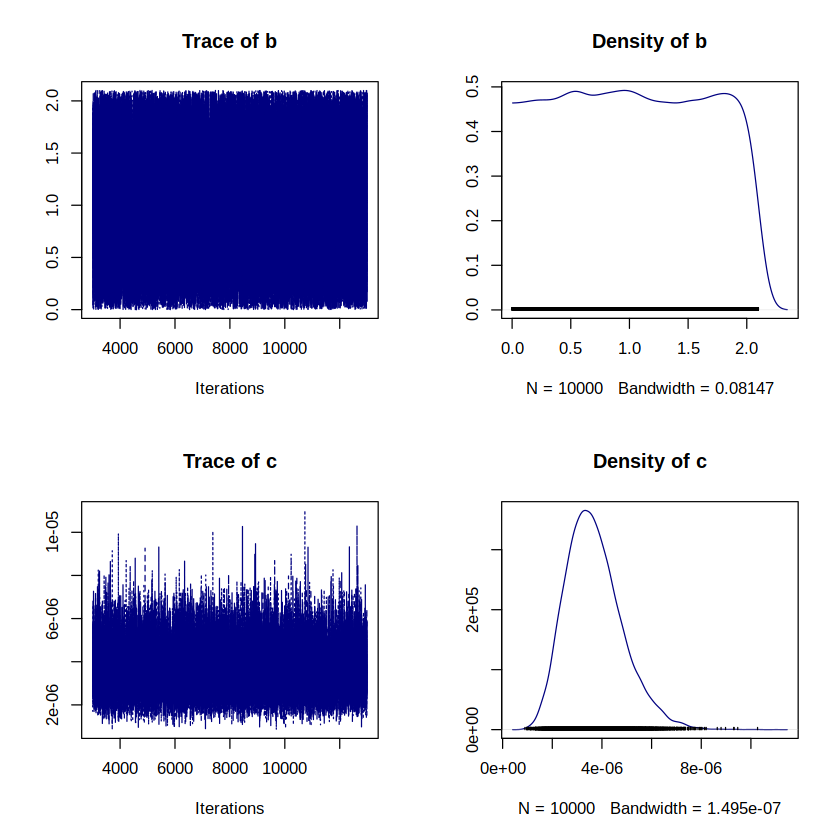

In [28]:
plot(samples, col = "navy")

In [29]:
quantiles <- summary(samples)$quantiles
quantiles_95_percent <- as.data.frame(quantiles[, c("2.5%", "97.5%")])
cat("95% credibility intervals:\n\n")
print(quantiles_95_percent)

95% credibility intervals:

          2.5%        97.5%
b 5.321472e-02 2.046701e+00
c 1.814842e-06 6.266965e-06
